In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

In [2]:
import DualwormFunctions as dw
import Observables as obs

#%load_ext line_profiler
#%load_ext memory_profiler

import RunBasis
import argparse
import StartStates as strst
import numpy as np

import AnalysisFunctions as af # functions to make the analysis code cleaner
import KagomeDrawing as kdraw
    #plots using matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

#import yep

In [3]:
nst = 1024
nsm = 1024
nips = 8;
nrps = 0;
nb = 64
measperiod =1;
nt = 64
nh = 1
ncores = 4
nmaxiter = 8
L = 8
J1 = 1
J2 = 0.02
J3 = 0
J3st = 0

tmin = 0.007
tmax = 60
h = 0


stroutput = "PSIJ1WORM_J1={0}_J2={1}_J3p={2}_L={3}_nrps={4}_Both".format(J1,J2,J3,L,nrps)

In [4]:
def genArgs():
    parser = argparse.ArgumentParser()
    
    parser.add_argument('-f', type = str)

    parser.add_argument('--L', type = int, default = L, help = 'Lattice side size')

    # COUPLINGS
    parser.add_argument('--J1', type = float, default = J1,
                        help = 'NN coupling') # nearest-neighbour coupling
    parser.add_argument('--J2', type = float, default = J2,
                        help = '2nd NN coupling') # 2nd NN coupling
    parser.add_argument('--J3', type = float, default = J3,
                        help = '3rd NN coupling') # 3rd NN coupling
    parser.add_argument('--J3st', type = float, default =J3st,
                       help = '3rd star NN coupling. If not given, set to J3 value. If given, can be different from J3.')
   
    parser.add_argument('--J4', type = float, default = 0.0,
                        help = '4th NN coupling') 
    #NUMBER OF STEPS AND ITERATIONS
    parser.add_argument('--nst', type = int, default = nst,
                        help = 'number of thermalisation steps') # number of thermalisation steps
    parser.add_argument('--nsm', type = int, default = nsm,
                        help = 'number of measurements steps') # number of measurement steps
    parser.add_argument('--nips', type = int, default = nips,
                        help = 'number of worm constructions per MC step')
    parser.add_argument('--nrps', type = int, default = nrps,
                        help = 'number of replica loops per MC step')
    parser.add_argument('--measperiod', type = int, default = measperiod,
                        help = 'number of nips worm building + swaps between measurements')
    parser.add_argument('--nb', type = int, default = nb,
                        help = 'number of bins')

    #PARALLELISATION
    parser.add_argument('--ncores', type = int, default = ncores,
                        help = 'number of threads to use')

    
    # INITIALISATION PARAMETERS
    parser.add_argument('--randominit', default = True, action ='store_true',
                        help = 'intialise the states randomly')
    parser.add_argument('--same', default = False, action = 'store_true',
                        help = '''initialise all temperatures with the same
                        state (debug purposes)''')
    parser.add_argument('--magninit', default = False, action = 'store_true',
                        help = '''initialise all the temperature with
                        one of the m=1/3 GS''')
    parser.add_argument('--magnstripes', default = False, action = 'store_true',
                       help = '''initialise all the temperature with
                       m=1/3 stripes''')
    parser.add_argument('--maxflip', default = False, action = 'store_true',
                       help = '''initialise all the temperature with
                       maximally flippable plateau''')
    parser.add_argument('--loadfromfile', default = False, action = 'store_true',
                       help = '''initialise all the states with
                       results from a previously performed simulations''')
    parser.add_argument('--filename', type = str, default = 'JustSomeJ1-1J21J31Test2_step1_folder',
                       help = '''initialise all the states with
                       results from a previously performed simulations''')
    
    #WORM PARAMETERS
    parser.add_argument('--nmaxiter', type = int, default = nmaxiter,
                        help = '''maximal number of segments in a loop update over the
                        size of the lattice (1 = 1times the number of dualbonds in the
                        lattice)''')
    parser.add_argument('--measupdate', default = False, action = 'store_true',
                       help = '''activate to mimic the action of the measuring tip''')
    parser.add_argument('--measupdatev', type = int, default = 0,
                       help = '''select the version of measupdate''')
    parser.add_argument('--measupdatesave', default = False, action = 'store_true',
                       help = '''activate to cancel measurement update before continuing''')
    parser.add_argument('--p', type = float, default = 0, 
                       help = '''version 0: prob of the measuring tip flipping the spin (number between 0 and 1)
                       \n version 1: htip/J (try 0, 2, 4)''')
    parser.add_argument('--ssf', default = False, action = 'store_true',
                        help = 'activate for single spin flip update')
    parser.add_argument('--notfullssfupdate', default = False, action = 'store_true',
                        help = 'whether to fully update the state or not at each ssf step *during the measurement phase*')
    parser.add_argument('--alternate', default = False, action = 'store_true',
                        help = 'activate for single spin flip update and dw update')
    parser.add_argument('--checkgs', default = True, action = 'store_true',
                        help = 'activate to debug ssf')
    
    #TEMPERATURE PARAMETERS
    parser.add_argument('--t_list', nargs = '+', type = float, default = [tmin,tmax],
                        help = 'list of limiting temperature values')
    parser.add_argument('--nt_list', nargs = '+', type = int, default = [nt],
                        help = 'list of number of temperatures in between the given limiting temperatures')
    parser.add_argument('--log_tlist', default = True, action='store_true',
                        help = 'state whether you want the temperature be spaced log-like or linear-like (activate if you want log)')
    parser.add_argument('--stat_temps_lims', nargs = '+', type = float,
                        help = '''limiting temperatures for the various ranges of
                        measurements''') 
                        #default will be set to none, and then we can decide what to do later on.
    #MAGNETIC FIELD PARAMETERS
    parser.add_argument('--h_list', nargs = '+', default = [0,h],type = float,
                        help = 'list of limiting magnetic field values')
    parser.add_argument('--nh_list', nargs = '+', default = [nh], type = int,
                        help = 'list of number of magnetic fields in between the given limiting temperatures')
    parser.add_argument('--stat_hfields_lims', nargs = '+', type = float,
                help = '''limiting magnetic fields for the various ranges of
                measurements''') 
    #MEASUREMENTS PARAMETERS
    parser.add_argument('--generatingMode', default = False, action = 'store_true',
                        help = 'activate if you want to generate a number of ground states and low energy states')
    parser.add_argument('--energy', default = True, action = 'store_true',
                        help = 'activate if you want to save the energy')
    parser.add_argument('--magnetisation', default = True, action = 'store_true',
                        help = 'activate if you want to save the magnetisation')
    parser.add_argument('--charges', default = False, action = 'store_true',
                        help = 'activate if you want to save the charges')
    parser.add_argument('--frustratedT', default = True, action = 'store_true',
                        help = 'activate if you want to save the frustrated triangles')
    parser.add_argument('--correlations', default = True, action = 'store_true',
                        help = 'activate if you want to save either central or all correlations')
    parser.add_argument('--both', default = True, action = 'store_true',
                        help = '''activate if you want to save both types of correlations''')
    parser.add_argument('--firstcorrelations', default = False, action = 'store_true',
                        help = 'activate if you want to save first correlations, otherwise will save central')
    parser.add_argument('--sref0', nargs = '+', type = int, default = [L-2, L-1, 0], help = 'ref spin 0')
    parser.add_argument('--sref1', nargs = '+', type = int, default = [L-2, L-1, 1], help = 'ref spin 1')
    parser.add_argument('--sref2', nargs = '+', type = int, default = [L-2, L-1, 2], help = 'ref spin 2')
    #SAVE
    parser.add_argument('--output', type = str, default = stroutput, help = 'saving filename (.pkl will be added)')
    parser.add_argument('--verbose',default = False, action = 'store_true',
                        help = 'activate verbosity')
    args = parser.parse_args()
    return args



In [5]:
def callRunBasis():
    args = genArgs()
    return RunBasis.main(args)

In [6]:
#%%prun -s  -T prun0
#yep.start(stroutput+'.log')
#%lprun -f dw.mcs_swaps 
[meanstat, swapst, swapsh, failedupdatesth, failedupdates, failedssfupdates] = callRunBasis()
#yep.stop()

-------------------Initialisation--------------------
./PSIJ1WORM_J1=1_J2=0.02_J3p=0_L=8_nrps=0_Both_folder/backup.hkl
Lattice side size:  8
J1  1
J2  0.02
J3  0
J3st  0
Couplings extracted
Hamiltonian expression (without field) computed
Number of temperatures:  64
Temperatures: [7.00000000e-03 8.08216023e-03 9.33161628e-03 1.07742311e-02
 1.24398661e-02 1.43629987e-02 1.65834367e-02 1.91471417e-02
 2.21071811e-02 2.55248257e-02 2.94708187e-02 3.40268398e-02
 3.92871959e-02 4.53607732e-02 5.23732910e-02 6.04699042e-02
 6.98182078e-02 8.06117061e-02 9.30738178e-02 1.07462501e-01
 1.24075593e-01 1.43256975e-01 1.65403690e-01 1.90974160e-01
 2.20497680e-01 2.54585369e-01 2.93942820e-01 3.39384710e-01
 3.91851658e-01 4.52429698e-01 5.22372759e-01 6.03128620e-01
 6.96368878e-01 8.04023550e-01 9.28321022e-01 1.07183418e+00
 1.23753365e+00 1.42884932e+00 1.64974131e+00 1.90478194e+00
 2.19925041e+00 2.53924203e+00 2.93179442e+00 3.38503318e+00
 3.90834007e+00 4.51254724e+00 5.21016141e+00 6.0

/home/jcolbois/myopic-dual-worm/dualworm-kagome/RunBasis.py:183: UserWarning: Lowest temperature state not in the ground state after thermalisation
  warnings.warn("Lowest temperature state not in the ground state after thermalisation")


ncores =  4
itermcs =  1024
iterreplicas =  0
ssf =  False
alternate =  False
ssffurther =  True
genMode =  False
saveupdates =  False
fullstateupdate =  True
measupdate =  False
statsfunctions [<function energy at 0x7f55c49171e0>, <function magnetisation at 0x7f55c4917400>, <function frustratedTriangles at 0x7f55c49176a8>, <function si at 0x7f55c4917510>, <function firstcorrelations at 0x7f55c4917598>, <function centralcorrelations at 0x7f55c4917488>]
Time for mcsevolve = 0.09416220872662961
Time for tempering = 1.8451828509569168e-06
Time for mapping to spins + computing statistics= 0.1633485471829772
Time for all measurements steps =  263.9849946498871
Energies size:  (64, 1)
RunBasis: Away from gs at t index  0
   en_states[t] =  -9.120000000000001
   ref_energy =  -391.67999999999995
Energies Checked
States Checked
ids2walker shape (64, 1)
Job done


In [7]:
import importlib
importlib.reload(af)

<module 'AnalysisFunctions' from '/home/jcolbois/myopic-dual-worm/dualworm-kagome/AnalysisFunctions.py'>

In [8]:
# Create a folder to save the pictures
foldername = "./" + stroutput + "_folder/" 
results_foldername = 'Results/'
os.makedirs(foldername + results_foldername, exist_ok = True)

filenamelist = ["backup"]
n = len(filenamelist)

In [9]:
[L, numsites, J1, J2, J3, J3st, J4, nb, num_in_bin, 
 htip, Ttip, pswitch, uponly, path,
 temperatures, nt,
 stat_temps, temperatures_plots, hfields, nh,
 stat_hfields, hfields_plots, listfunctions, sref, idswalker] =\
af.LoadParameters(foldername, filenamelist)

In [10]:
s_ijl, ijl_s = kdraw.createspinsitetable(L[0])
print("nb ", nb, "num_in_bin ", num_in_bin)
swapst_th, swapsh_th, swapst, swapsh = af.LoadSwaps(foldername, filenamelist, nb, num_in_bin, nh, nt)

n = len(L)
failedth, failedssfth, failed, failedssf = \
af.LoadUpdates(foldername, filenamelist, nb, num_in_bin, [9*L[i]**2 for i in range(n)])


nb  [64] num_in_bin  [16]


/home/jcolbois/myopic-dual-worm/dualworm-kagome/AnalysisFunctions.py:361: RuntimeWarning: invalid value encountered in true_divide
  swapst = 4*np.array(swapst)/(nsms*nrps*measperiod*nh)
/home/jcolbois/myopic-dual-worm/dualworm-kagome/AnalysisFunctions.py:362: RuntimeWarning: invalid value encountered in true_divide
  swapsh = 4*np.array(swapsh)/(nsms*nrps*measperiod*nt)


In [11]:
tidmin = 0
tidmax = nt
af.SwapsAnalysis(L, 0, tidmin, tidmax, temperatures, hfields,
                 foldername, results_foldername, swapst, swapsh)

In [12]:
af.FailedAnalysis(L, 0, tidmin, tidmax, temperatures, hfields,
                 foldername, results_foldername,failed, failedssf)

[-0.01583333]
No jackknife analysis -- binning level:  0  -- number of bins:  64
(64, 2, 64, 1)


/home/jcolbois/myopic-dual-worm/dualworm-kagome/AnalysisFunctions.py:693: UserWarning: Negative variances num error: 4.405647E-19
  warnings.warn("Negative variances num error: %E" % err)


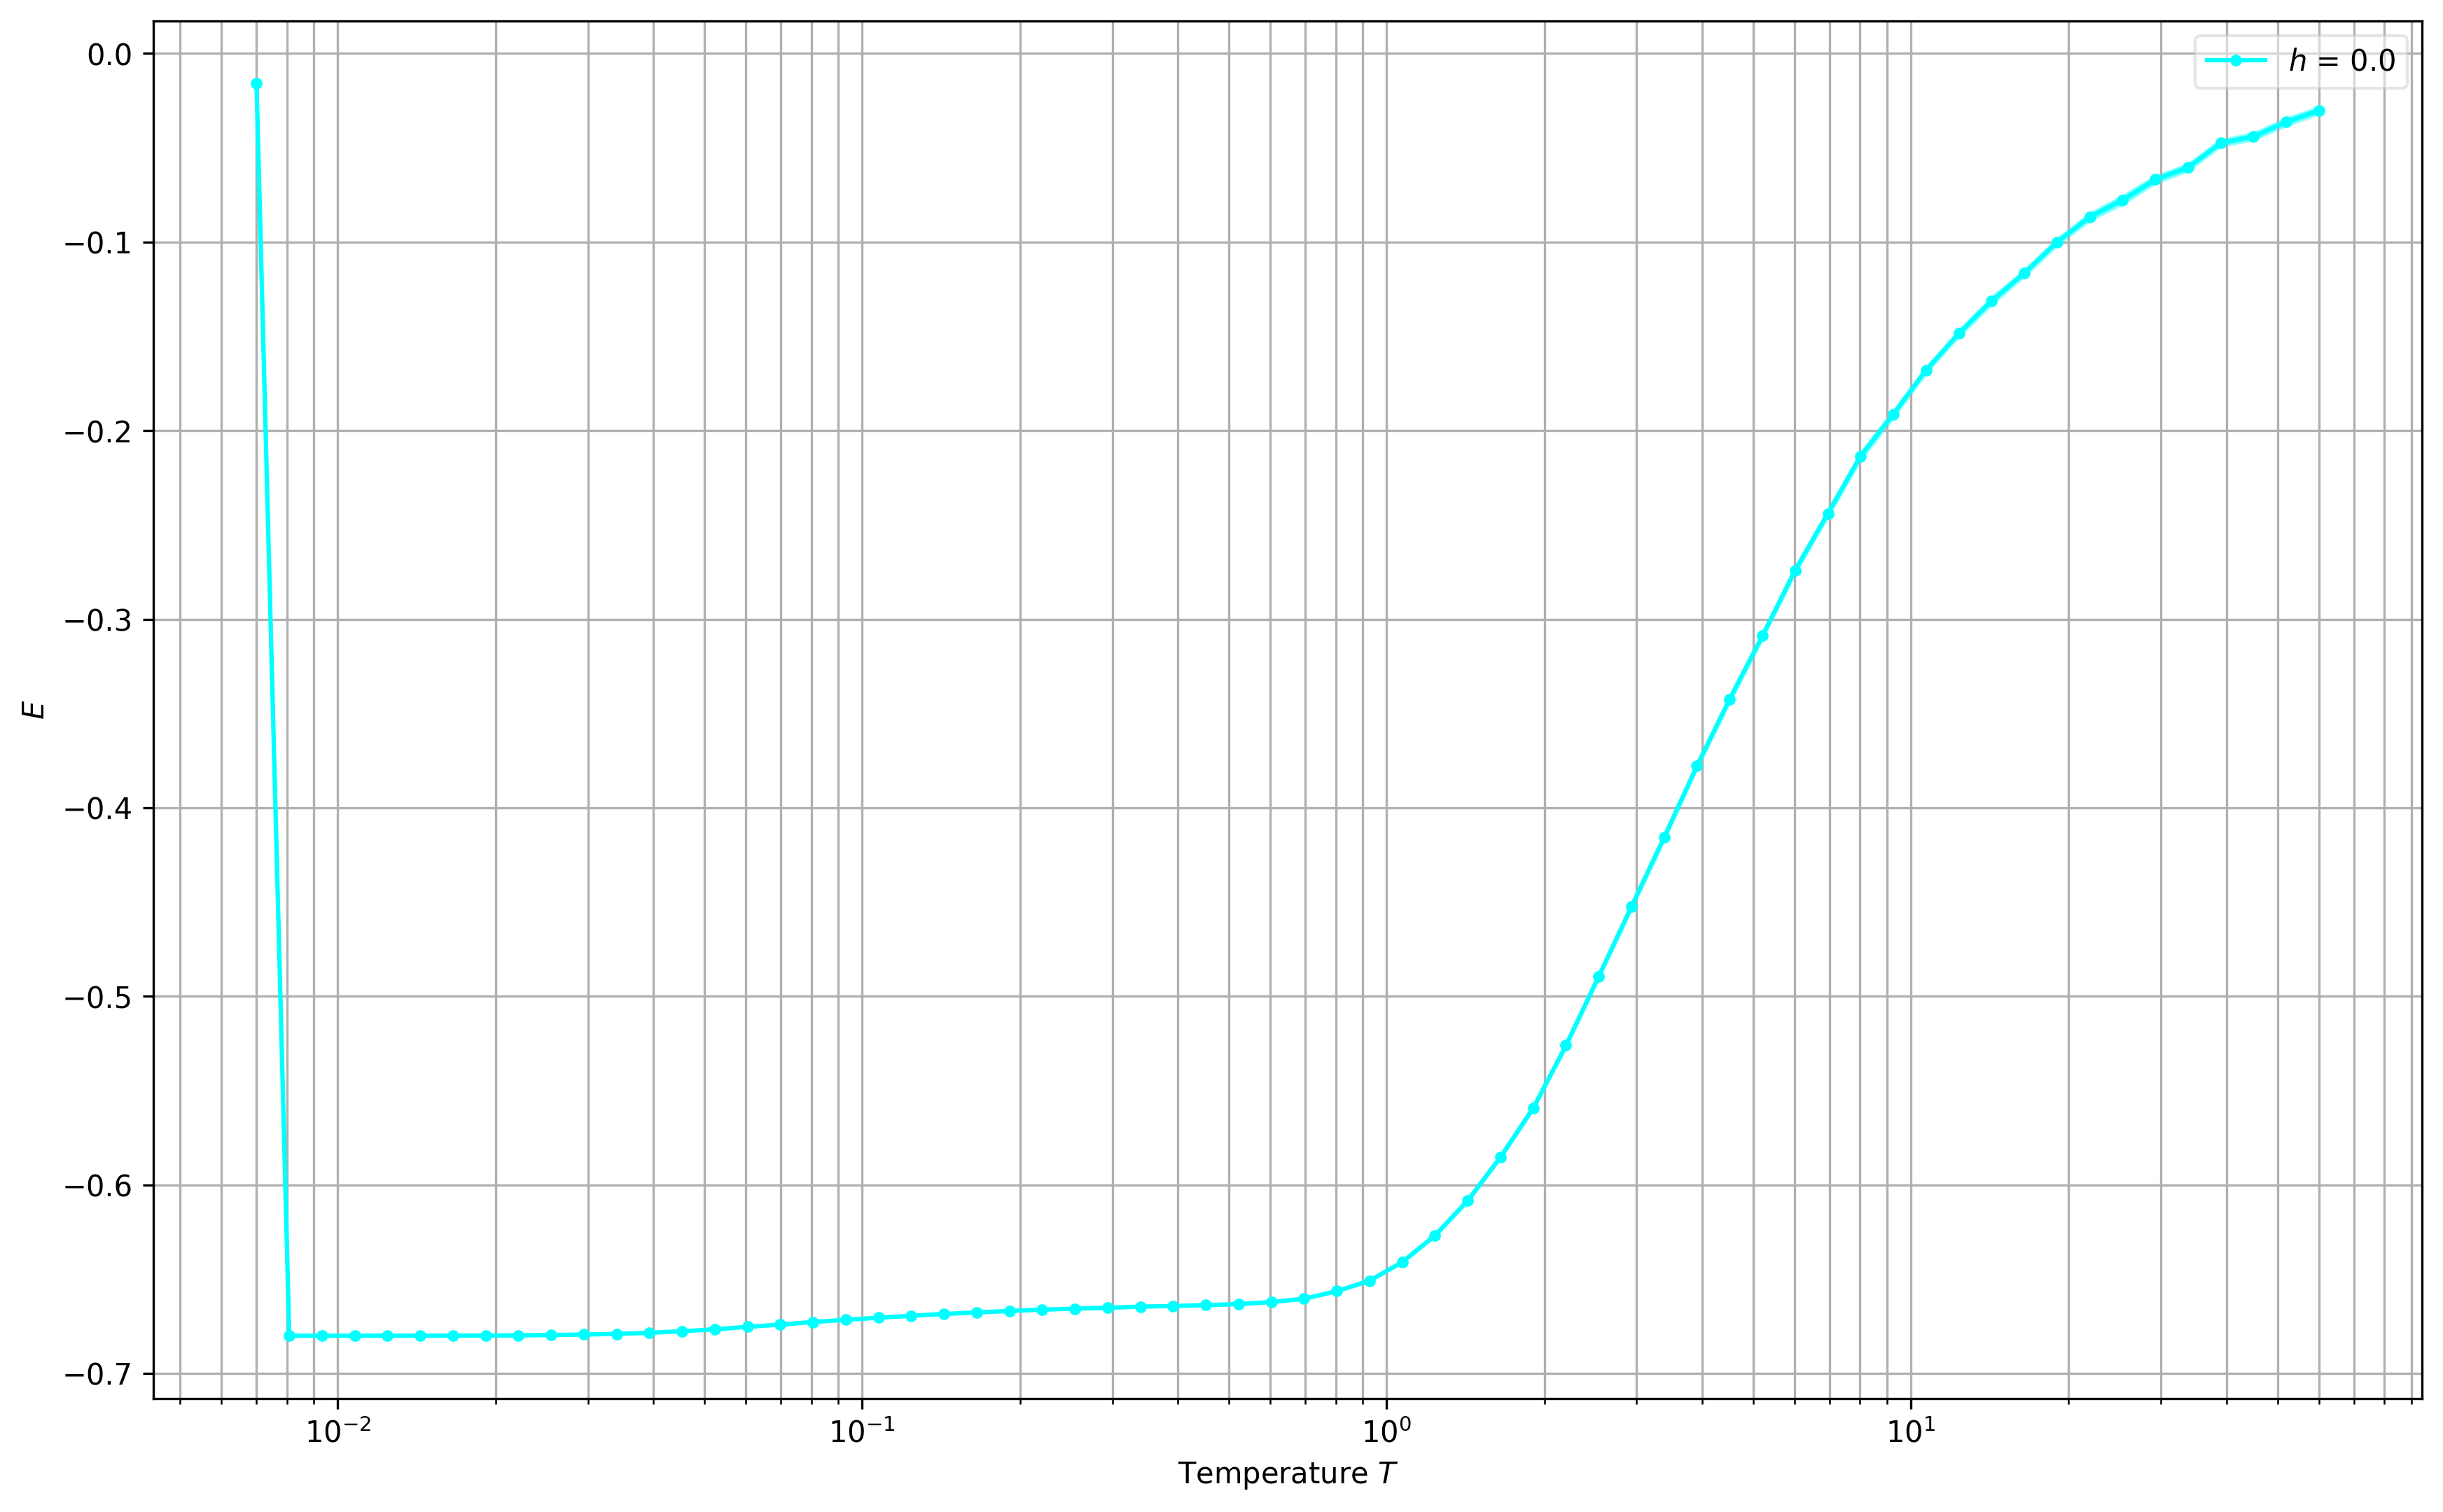

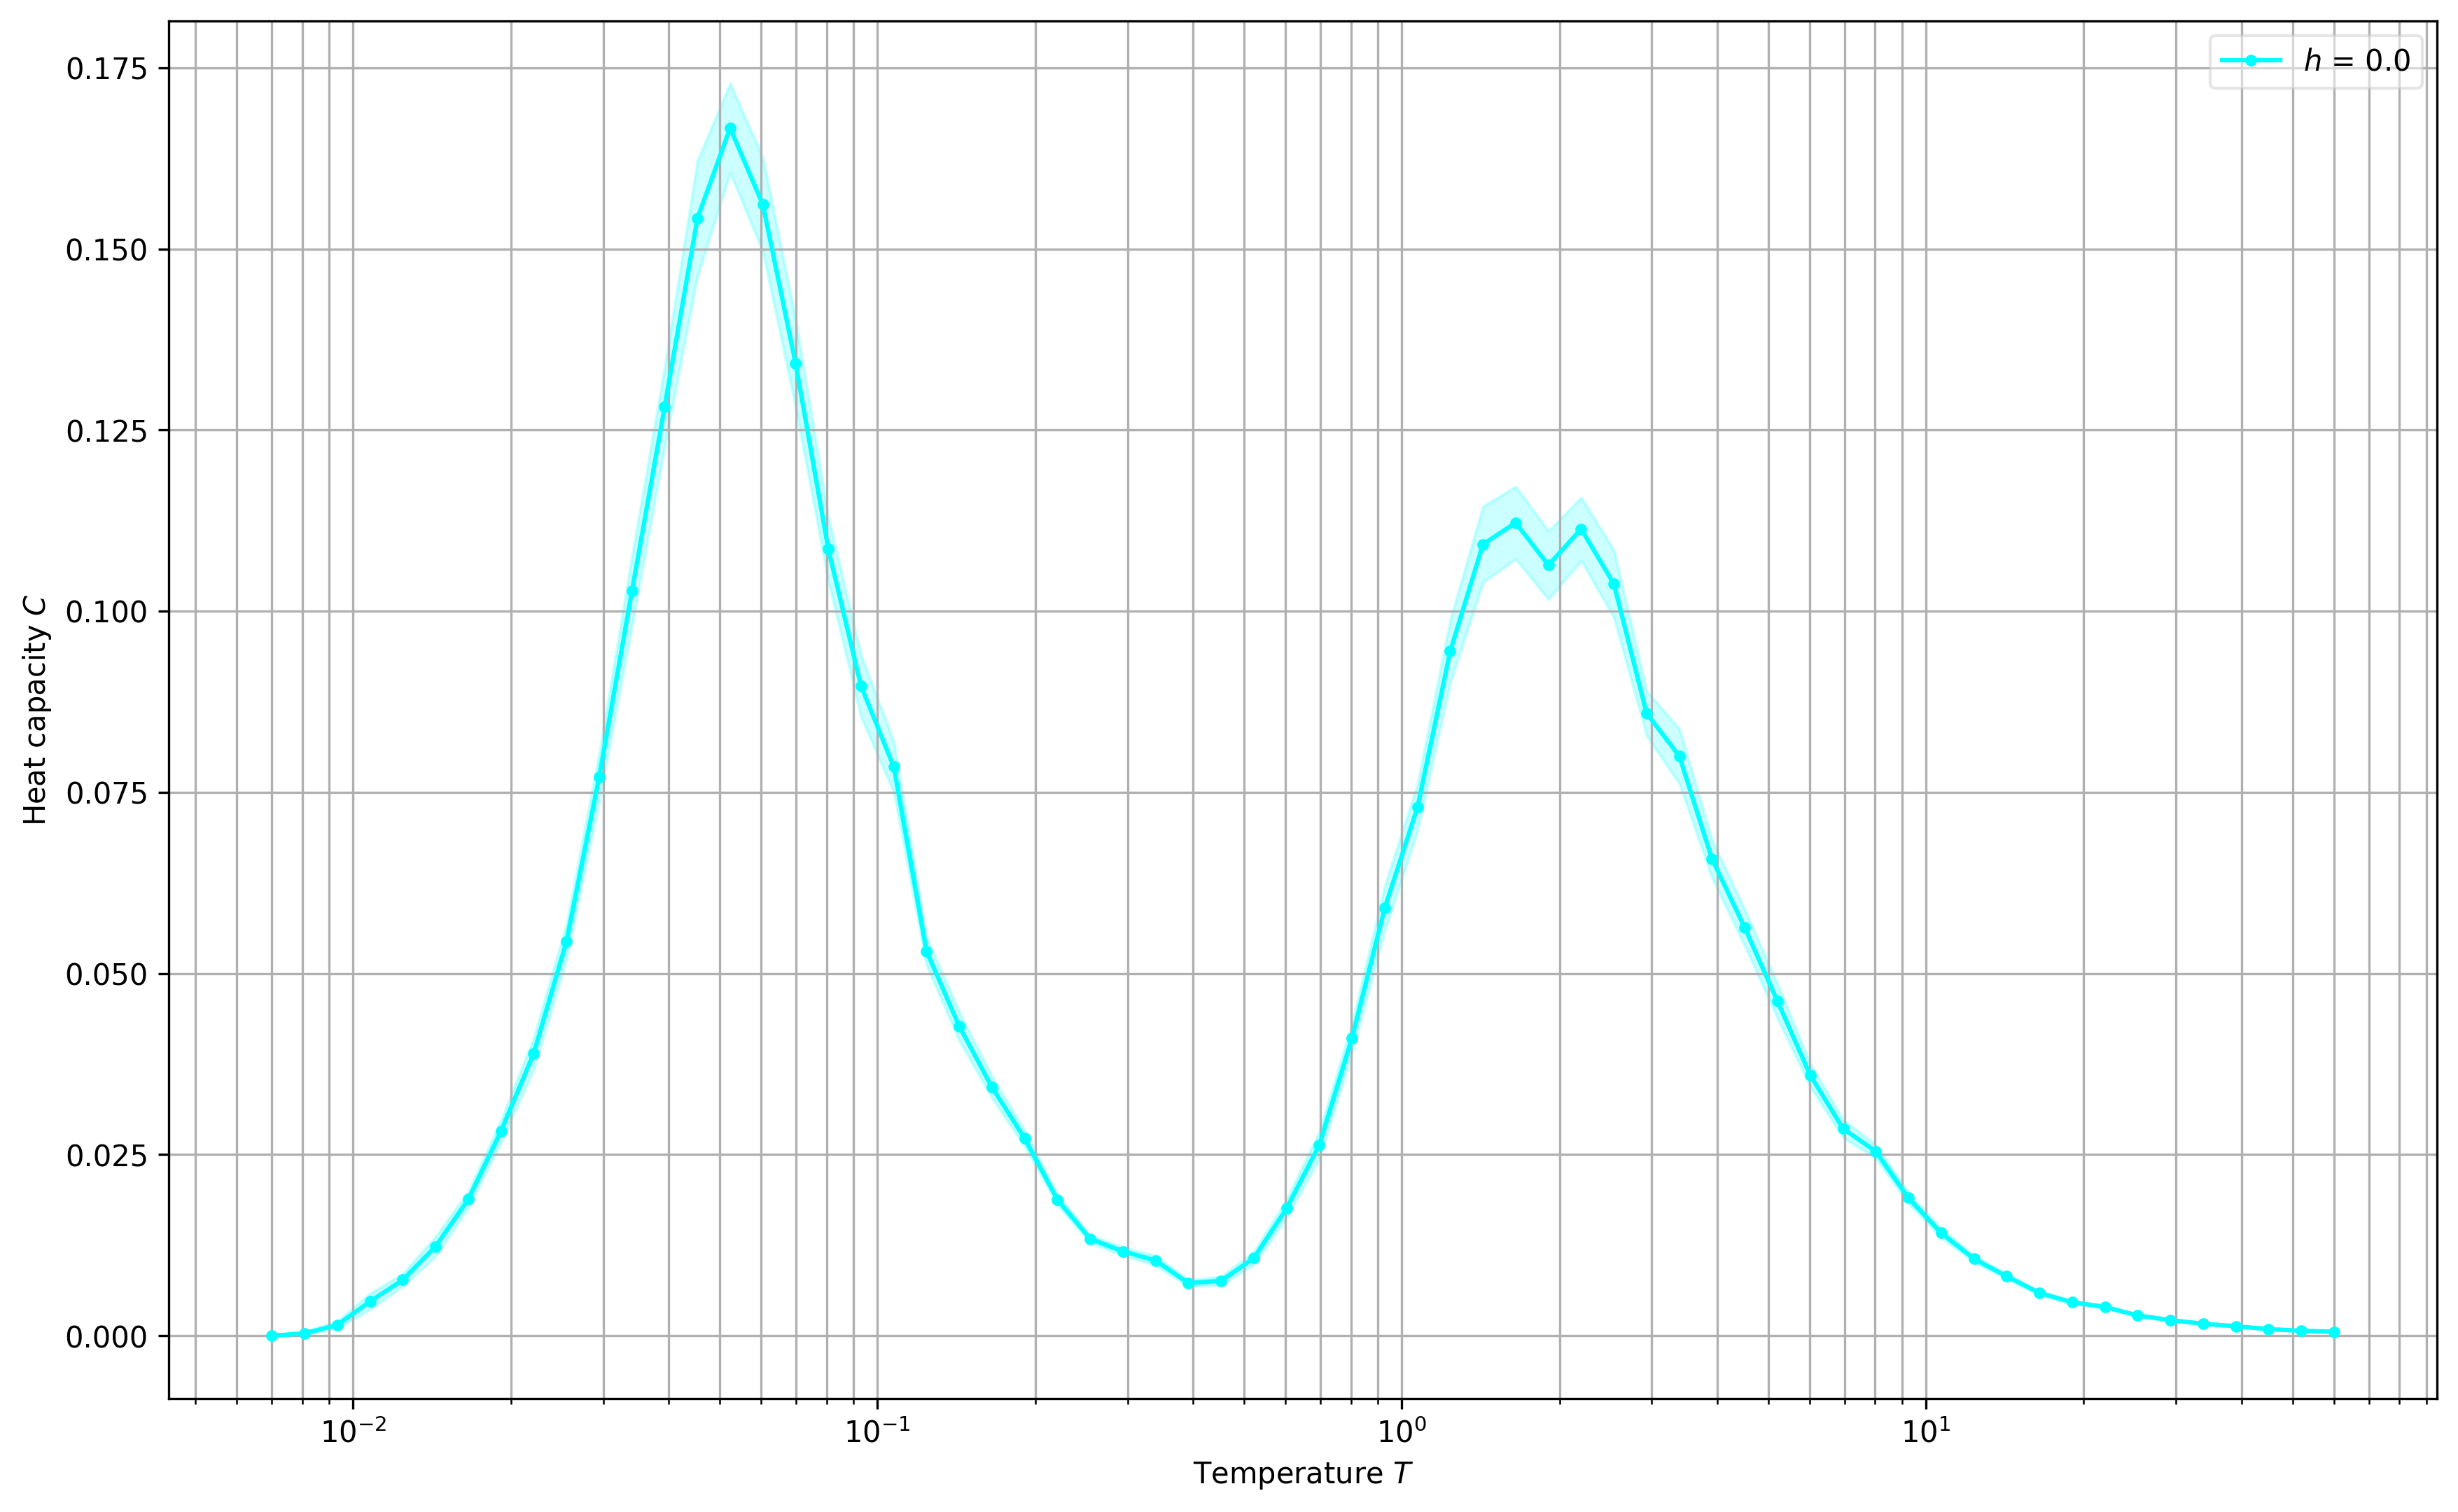

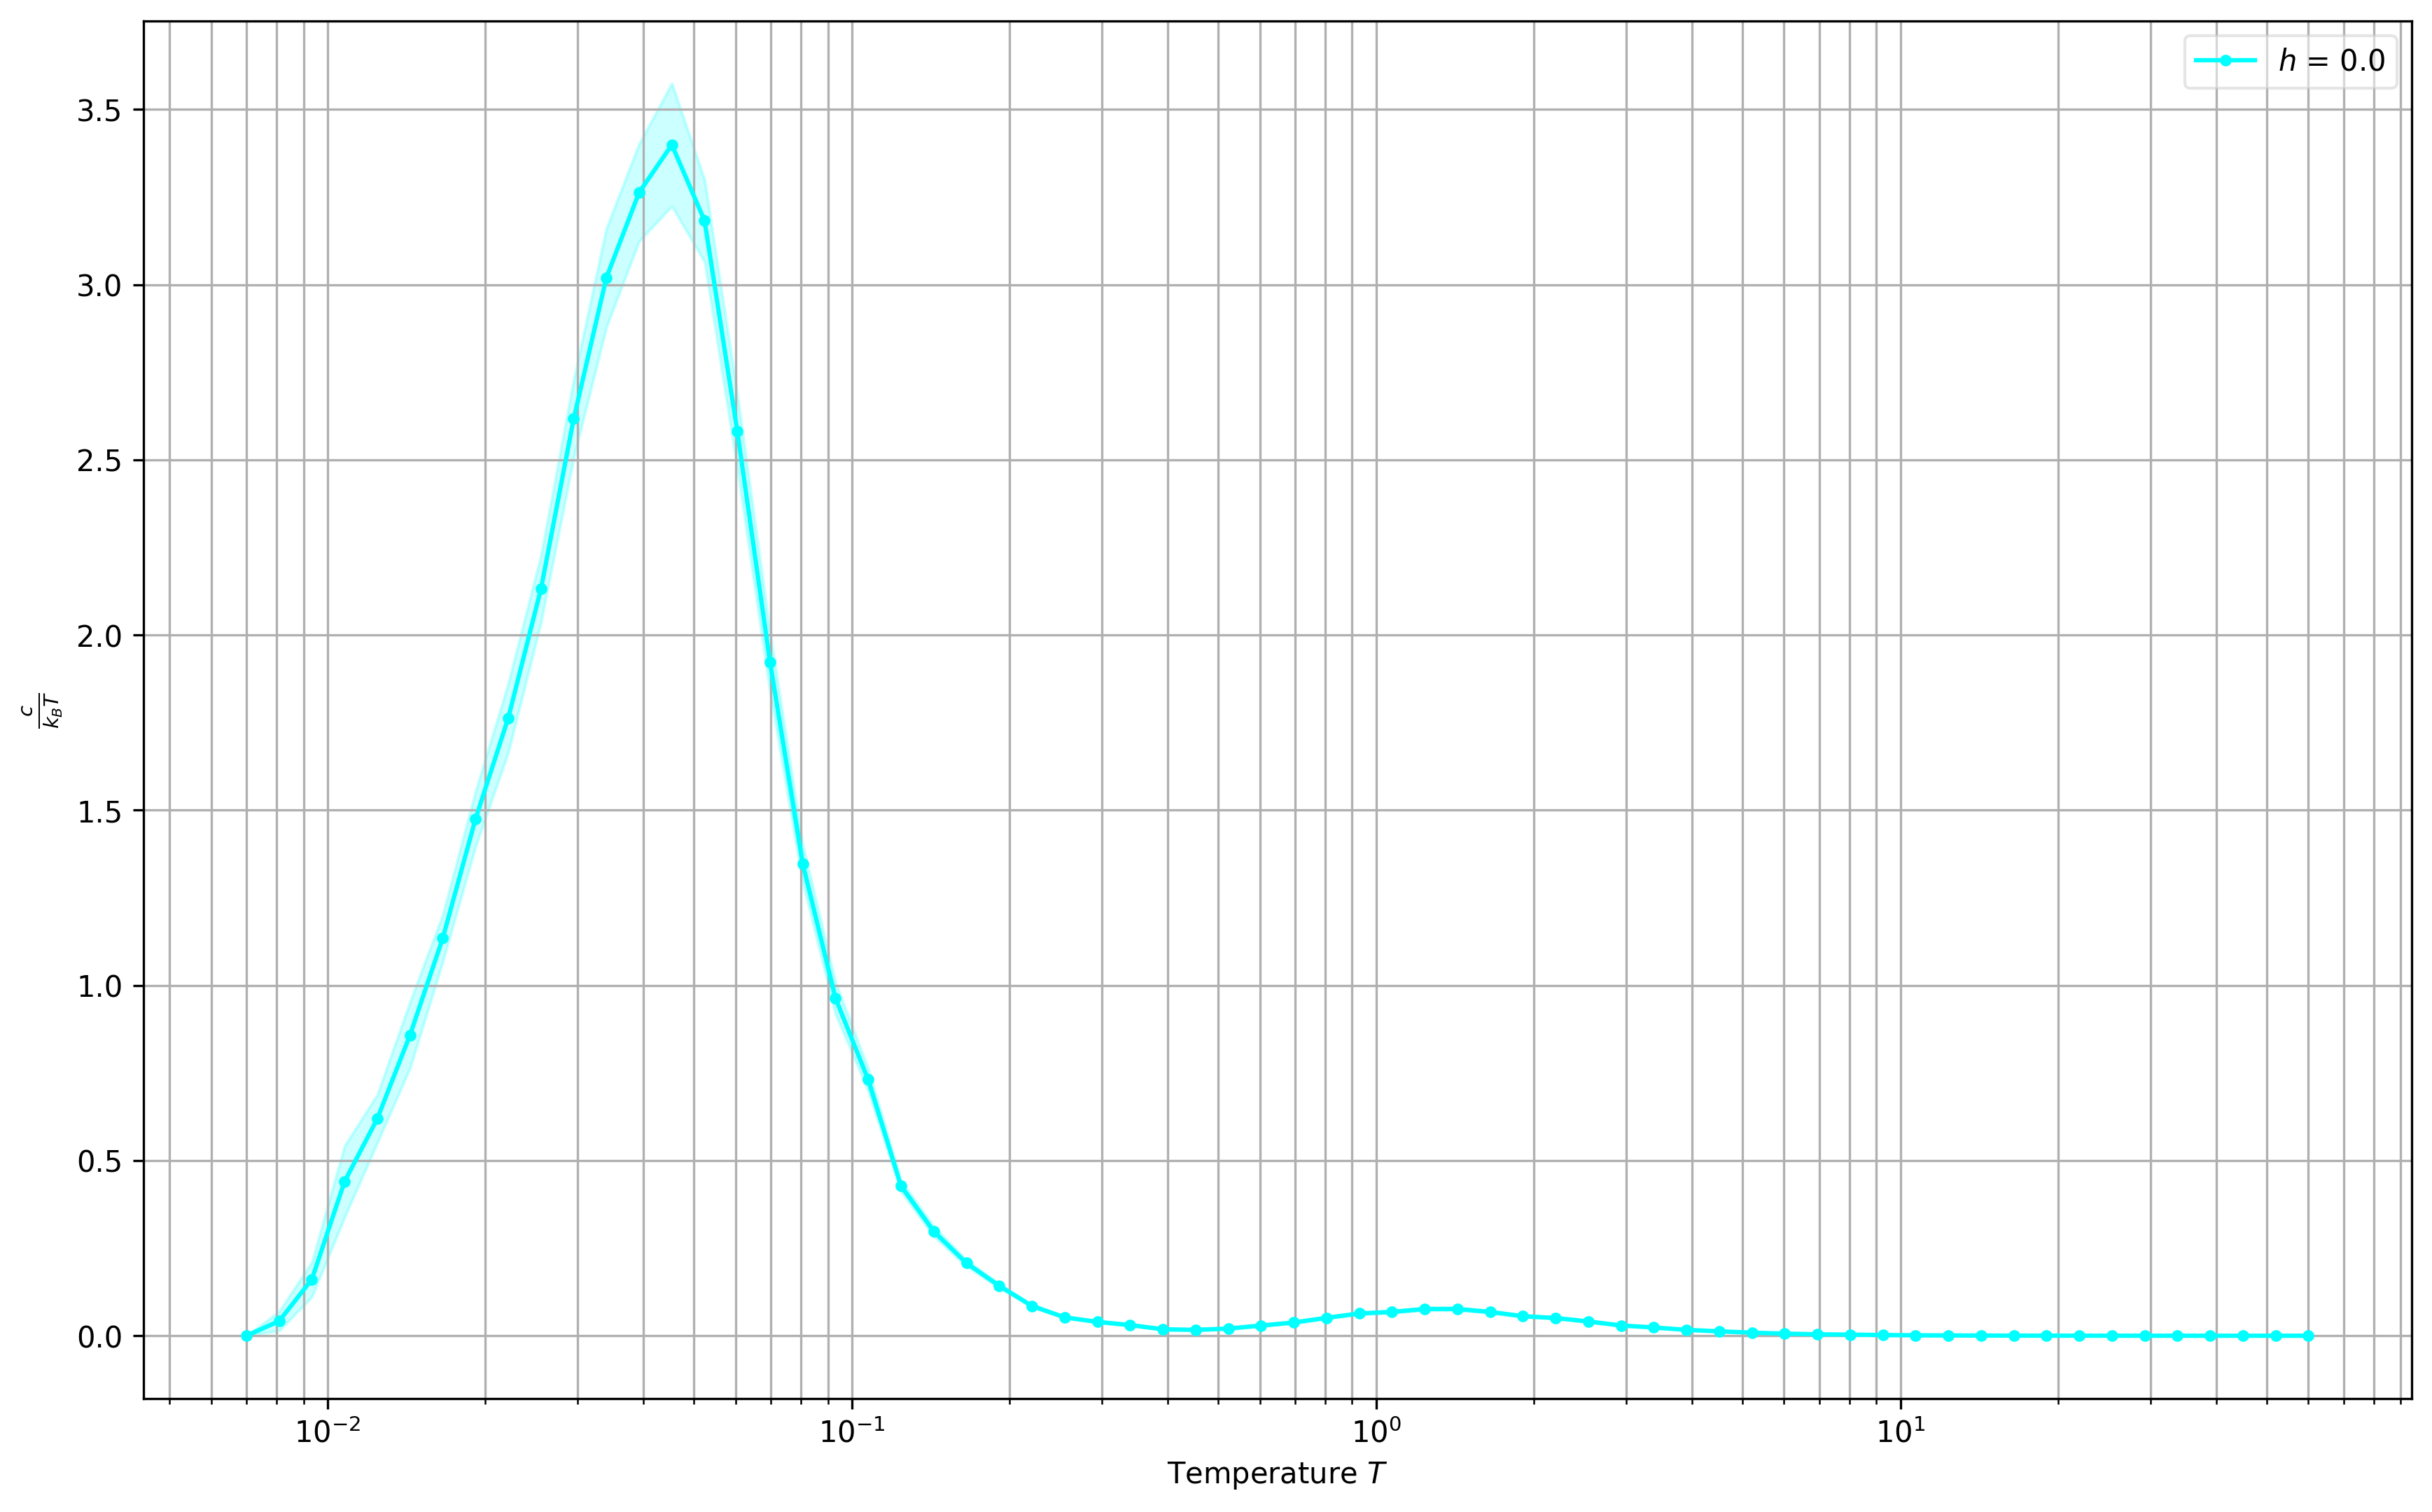

In [13]:
kw = {'binning': False, 'plzplot': True, 'plotmin': 0, 'plotmax': 16}
[t_h_MeanE, t_h_MeanEsq, t_h_varMeanE, t_h_varMeanEsq,  t_h_VarE, t_h_ErrVarE,C, ErrC,\
            t_h_S, t_h_Smin, t_h_Smax, MergedData]= \
 af.LoadEnergy(foldername, filenamelist, numsites,
               nb, stat_temps, temperatures, stat_hfields, listfunctions, **kw)

tidmin = 0
tidmax = [len(stat_temps[i]) for i in range(n)]
temperatures_plots = np.array(temperatures_plots)
### Energy
S0 = np.log(2)
kw = {'gscheck': False}
af.BasicPlotsE(L, 0, tidmin, tidmax, temperatures_plots, hfields_plots, foldername,
                results_foldername, filenamelist, t_h_MeanE, t_h_MeanEsq, t_h_varMeanE,
                t_h_varMeanEsq, C, ErrC, J1, J2, J3, J4, **kw)
plt.show()

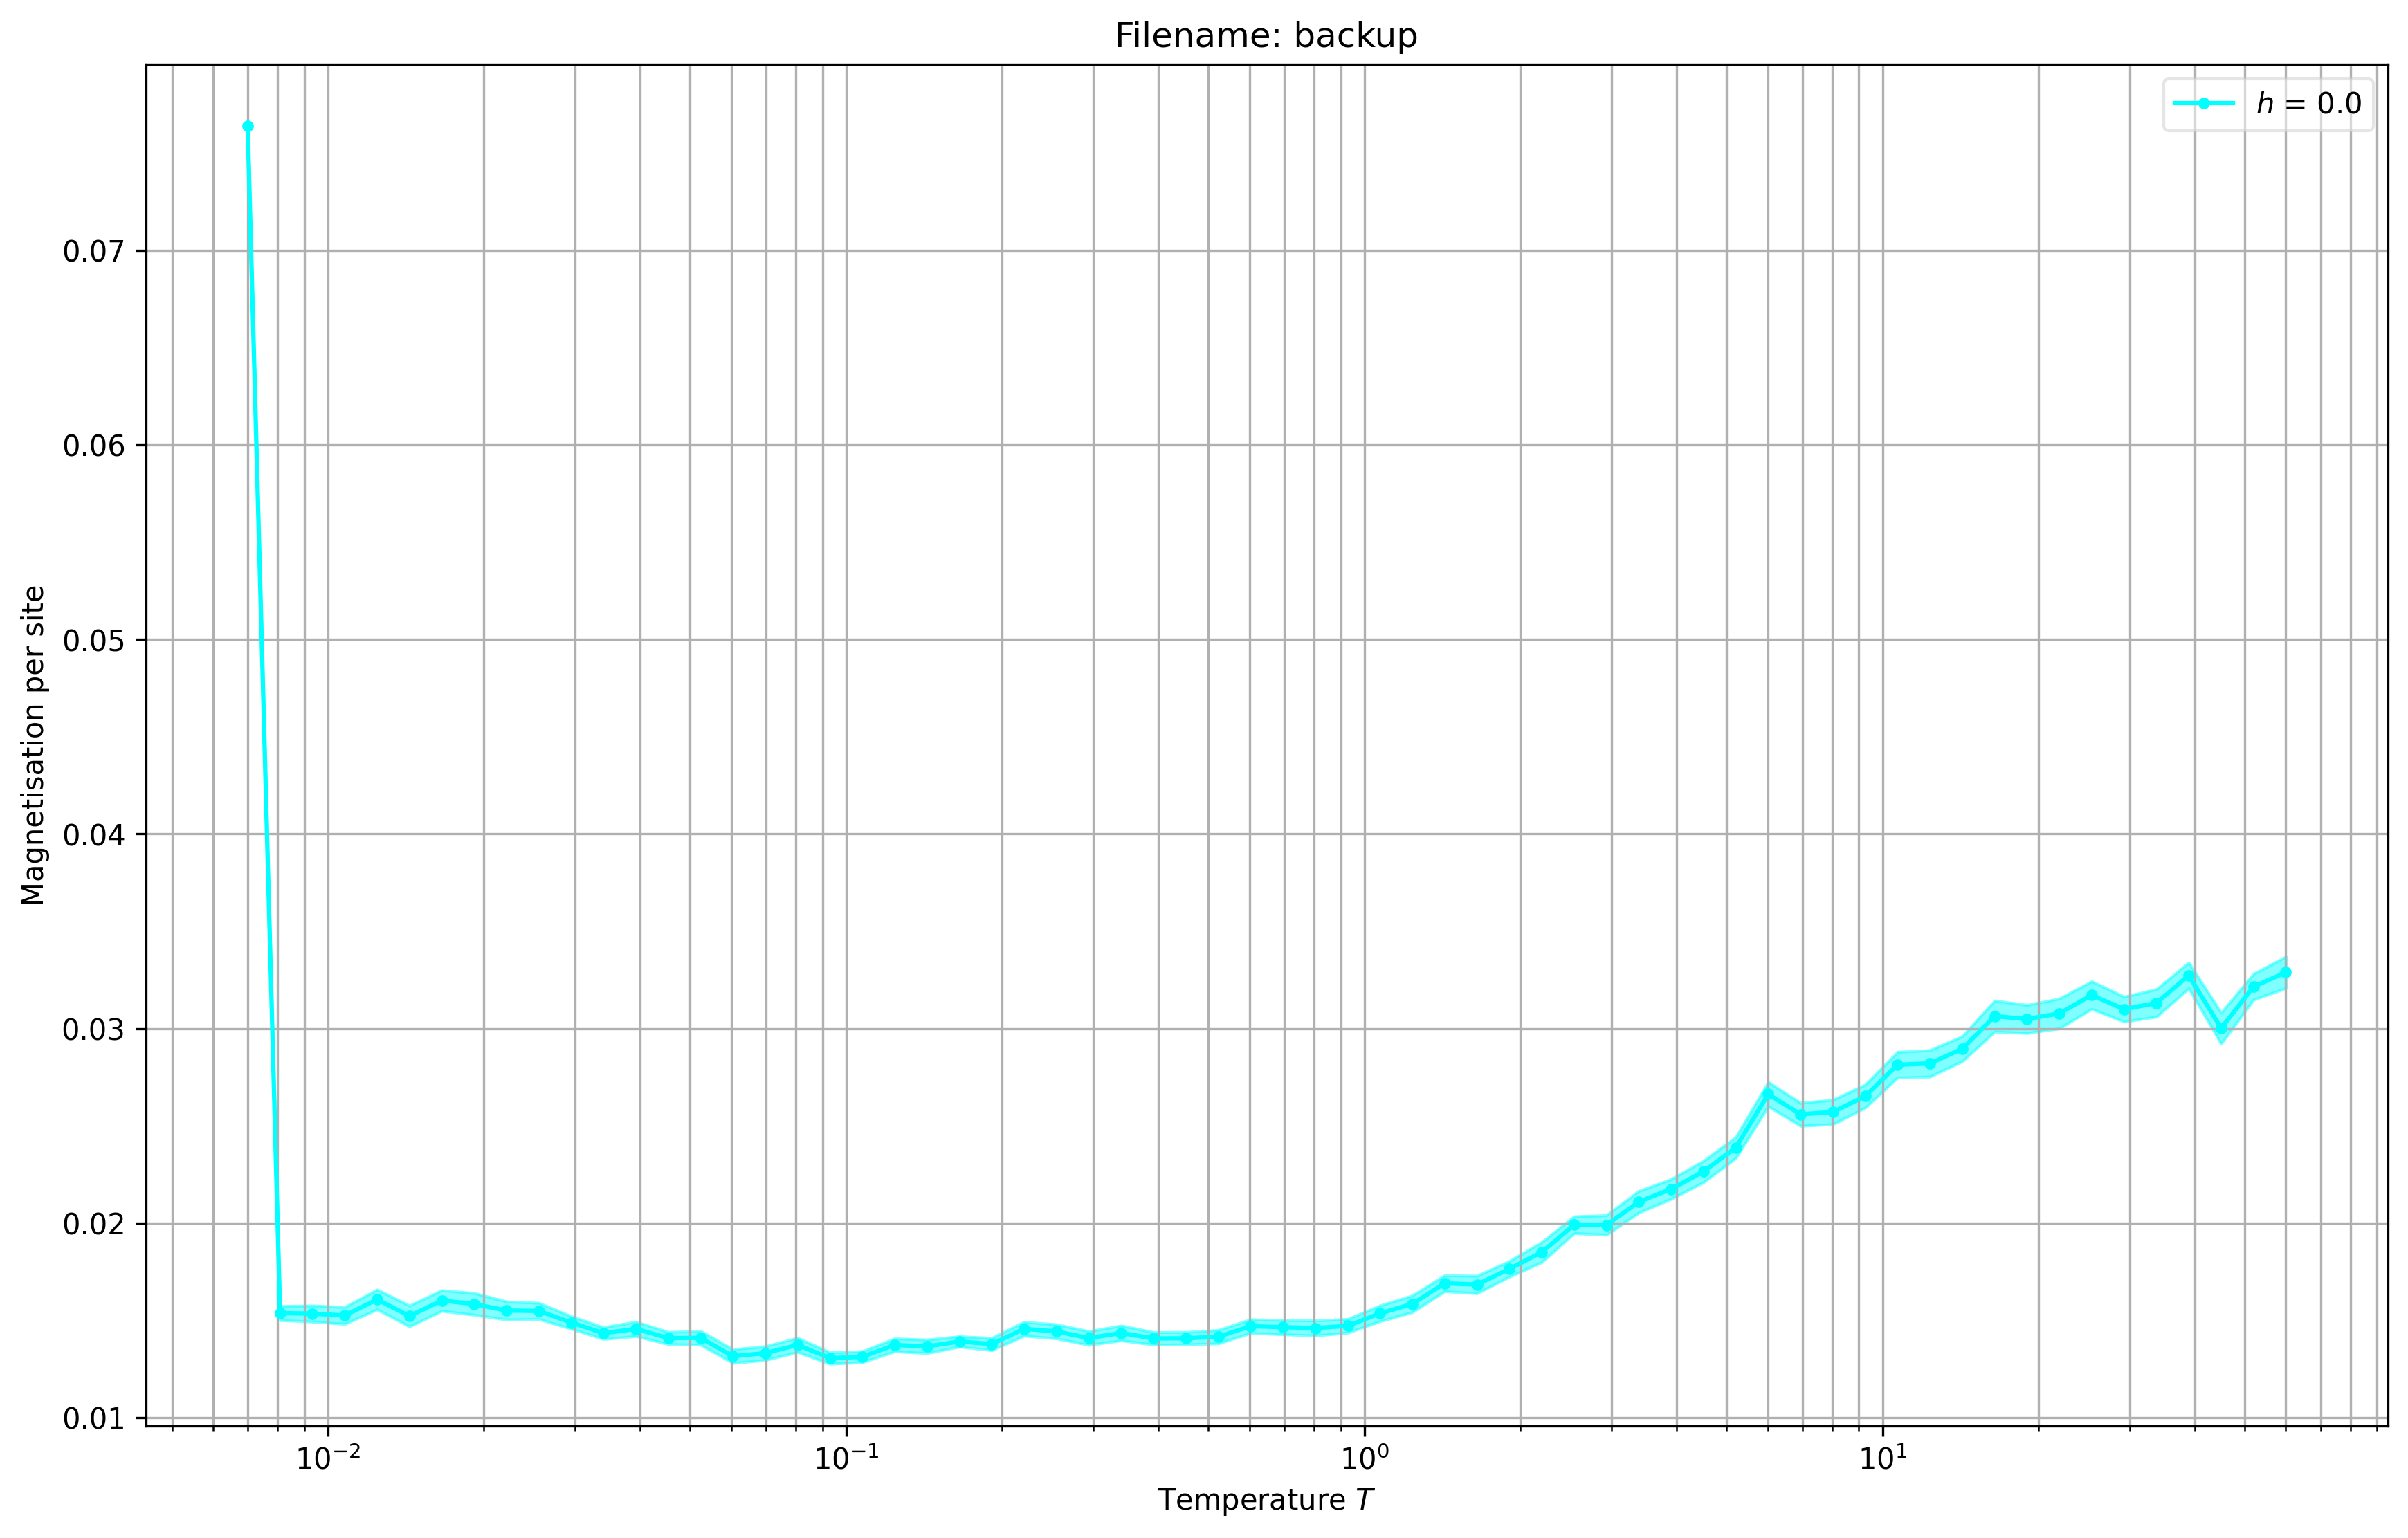

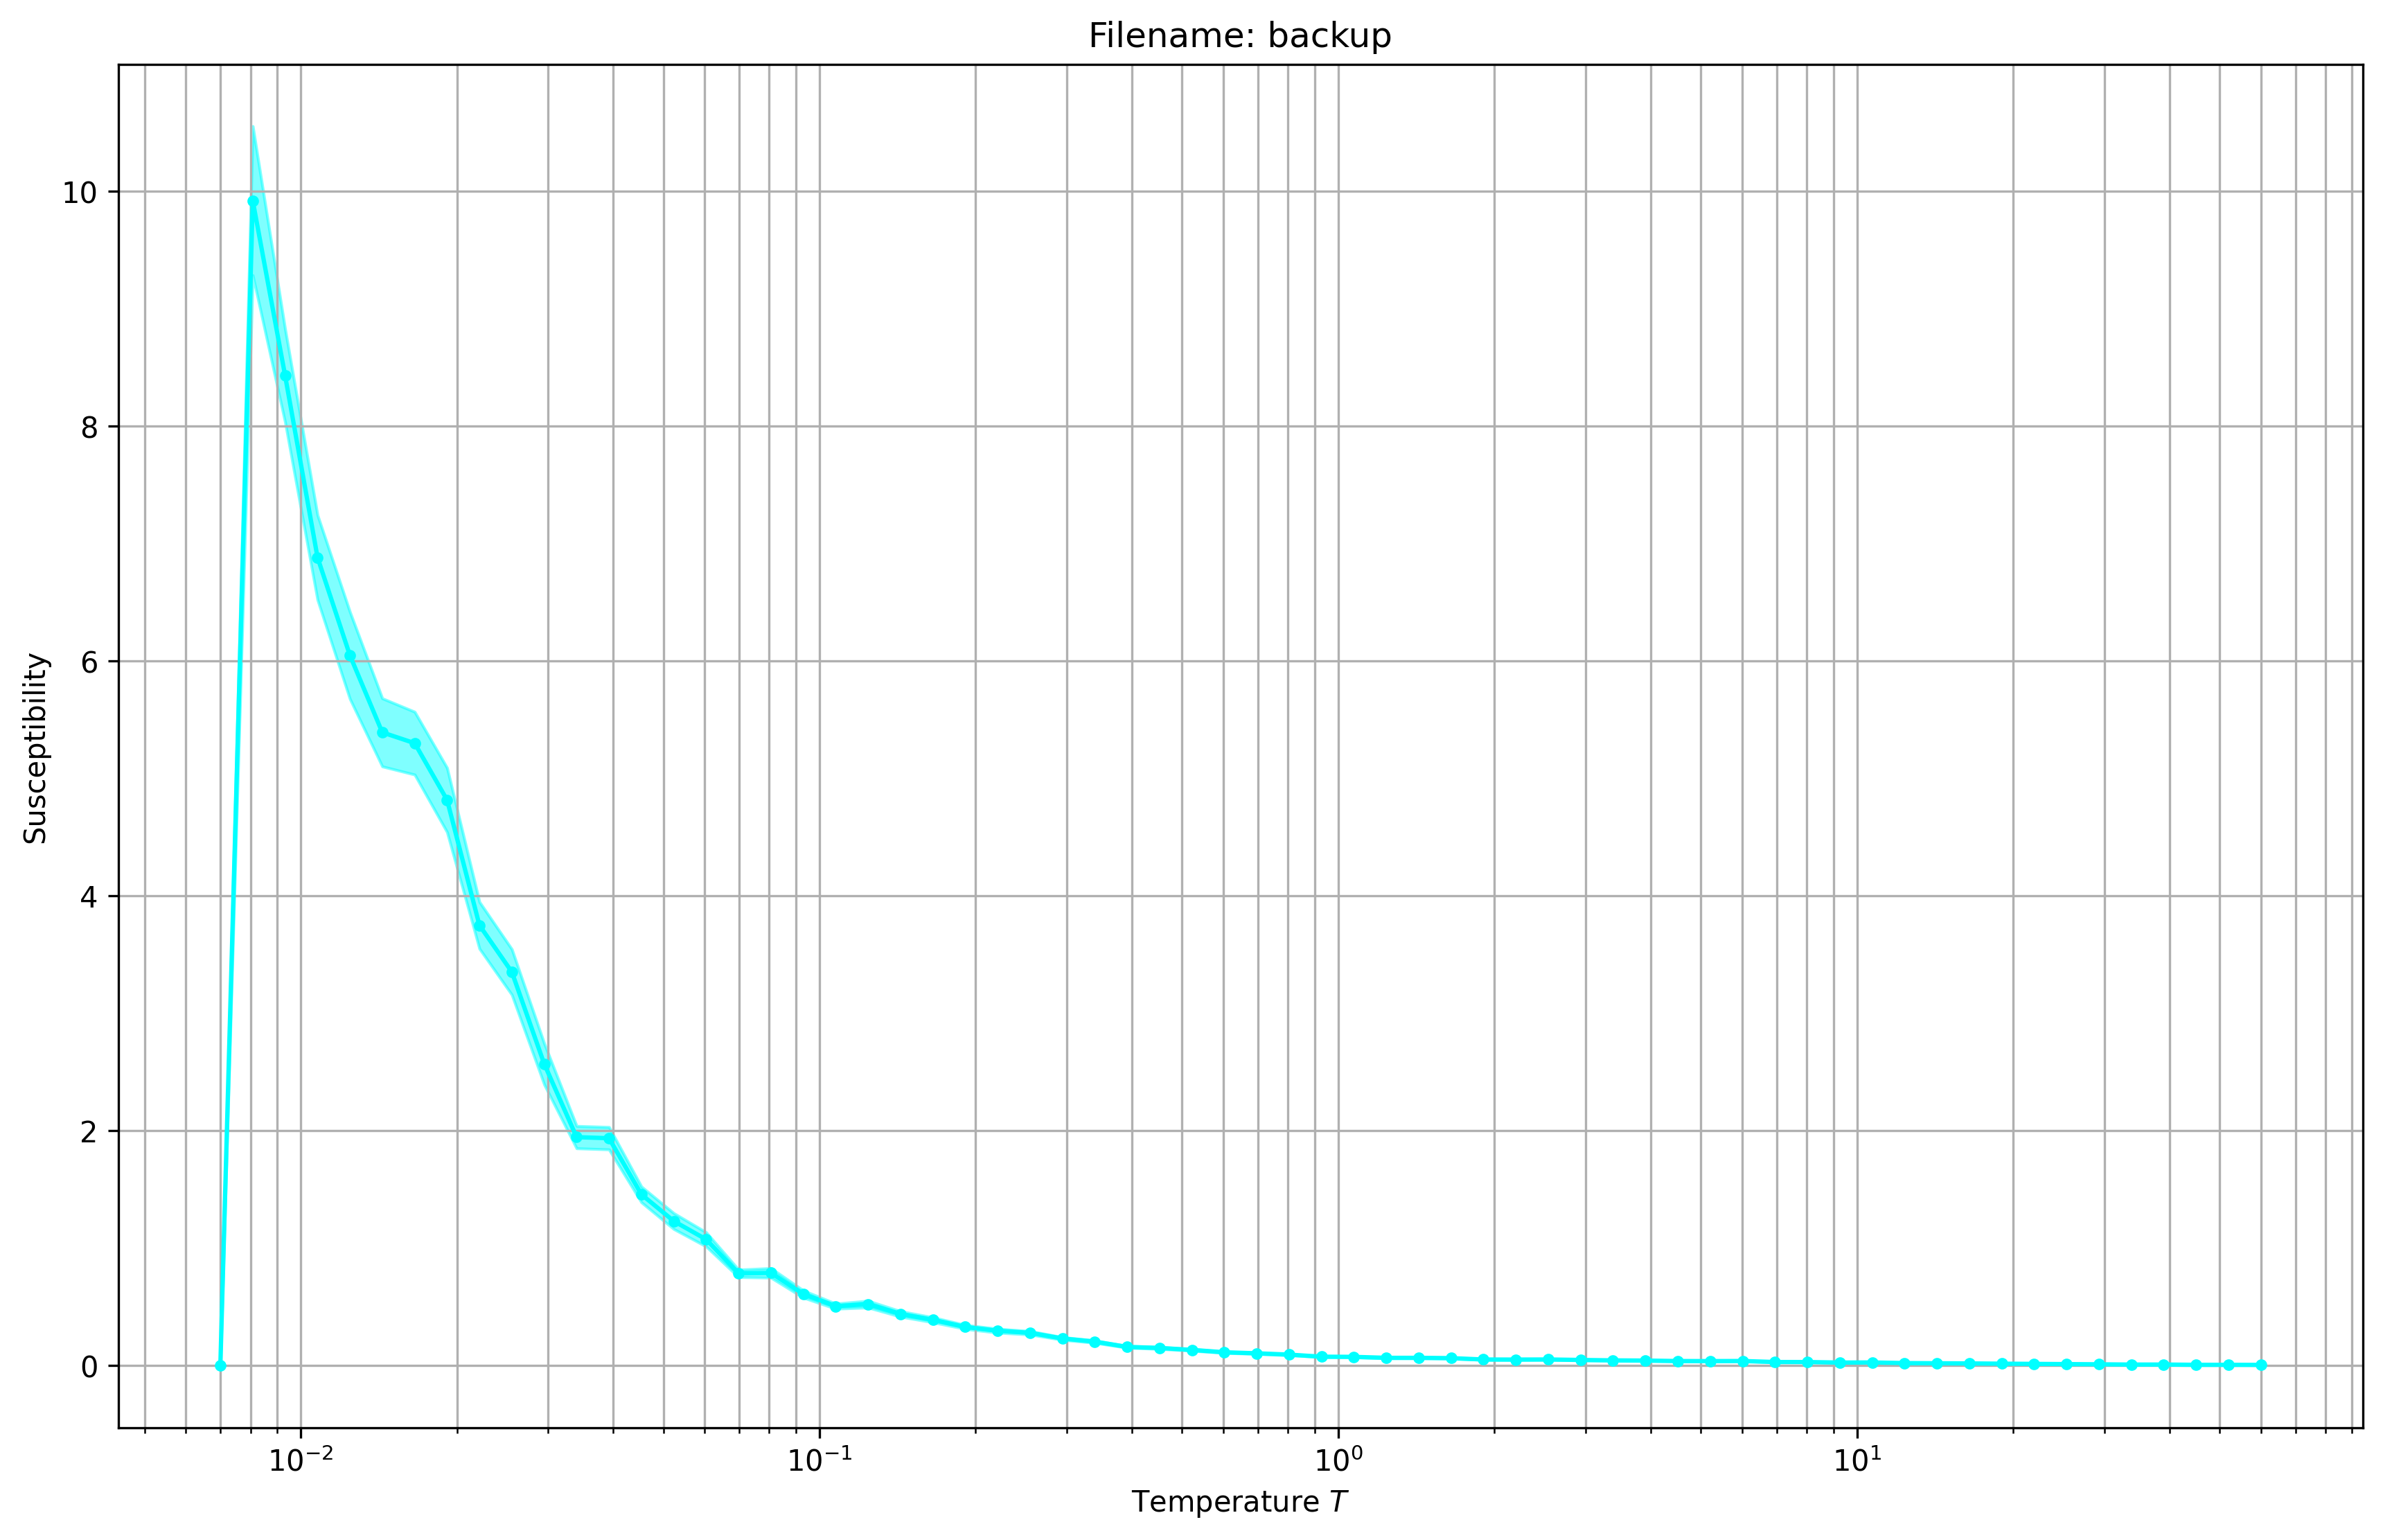

In [14]:
kw = {'binning': False, 'plzplot': True, 'plotmin': 0, 'plotmax': 16}
[t_h_MeanM, t_h_MeanMsq, t_h_varMeanM, t_h_varMeanMsq, Chi, ErrChi] = \
 af.LoadMagnetisation(foldername, filenamelist, numsites,
               nb, stat_temps, temperatures, stat_hfields,
               listfunctions, **kw)
tidmin = 0
tidmax = [len(stat_temps[i]) for i in range(n)]
temperatures_plots = np.array(temperatures_plots)
### Energy
S0 = np.log(2)
kw = {'gscheck': False}
af.BasicPlotsM(L, 0, tidmin, tidmax, temperatures_plots, hfields_plots, foldername,
                results_foldername, filenamelist, t_h_MeanM, t_h_MeanMsq, t_h_varMeanM,
                t_h_varMeanMsq, Chi, ErrChi, J1, J2, J3, J4, **kw)
plt.show()

In [15]:
rmmag = True

In [16]:
kw = {'rmmag':rmmag}
t_h_MeanFc, t_h_varMeanFc, t_h_MeanSi, t_h_varMeanSi= \
 af.LoadFirstCorrelations(foldername, filenamelist, listfunctions, stat_temps[0:4], stat_hfields, nb, t_h_varMeanMsq,**kw)


(64, 1, 4)
(64, 1, 576)


In [17]:
# Introducing the experimental values for the plots below:
## <sisj>-<si><sj>:
NN1exp = -0.218;
NN1experr = 0.005;
NN2exp = 0.021;
NN2experr = 0.004;
NN3pexp = 0.063;
NN3pexperr = 0.005;
NN3sexp = -0.003;
NN3sexperr = 0.005;

mexp = -0.193;

rmexpmag = True

if not rmexpmag:
    NN1exp += mexp**2;
    NN2exp += mexp**2;
    NN3pexp += mexp**2;
    NN3sexp += mexp**2;
    

print(NN1exp)
print(NN2exp)
print(NN3pexp)
print(NN3sexp)

-0.218
0.021
0.063
-0.003


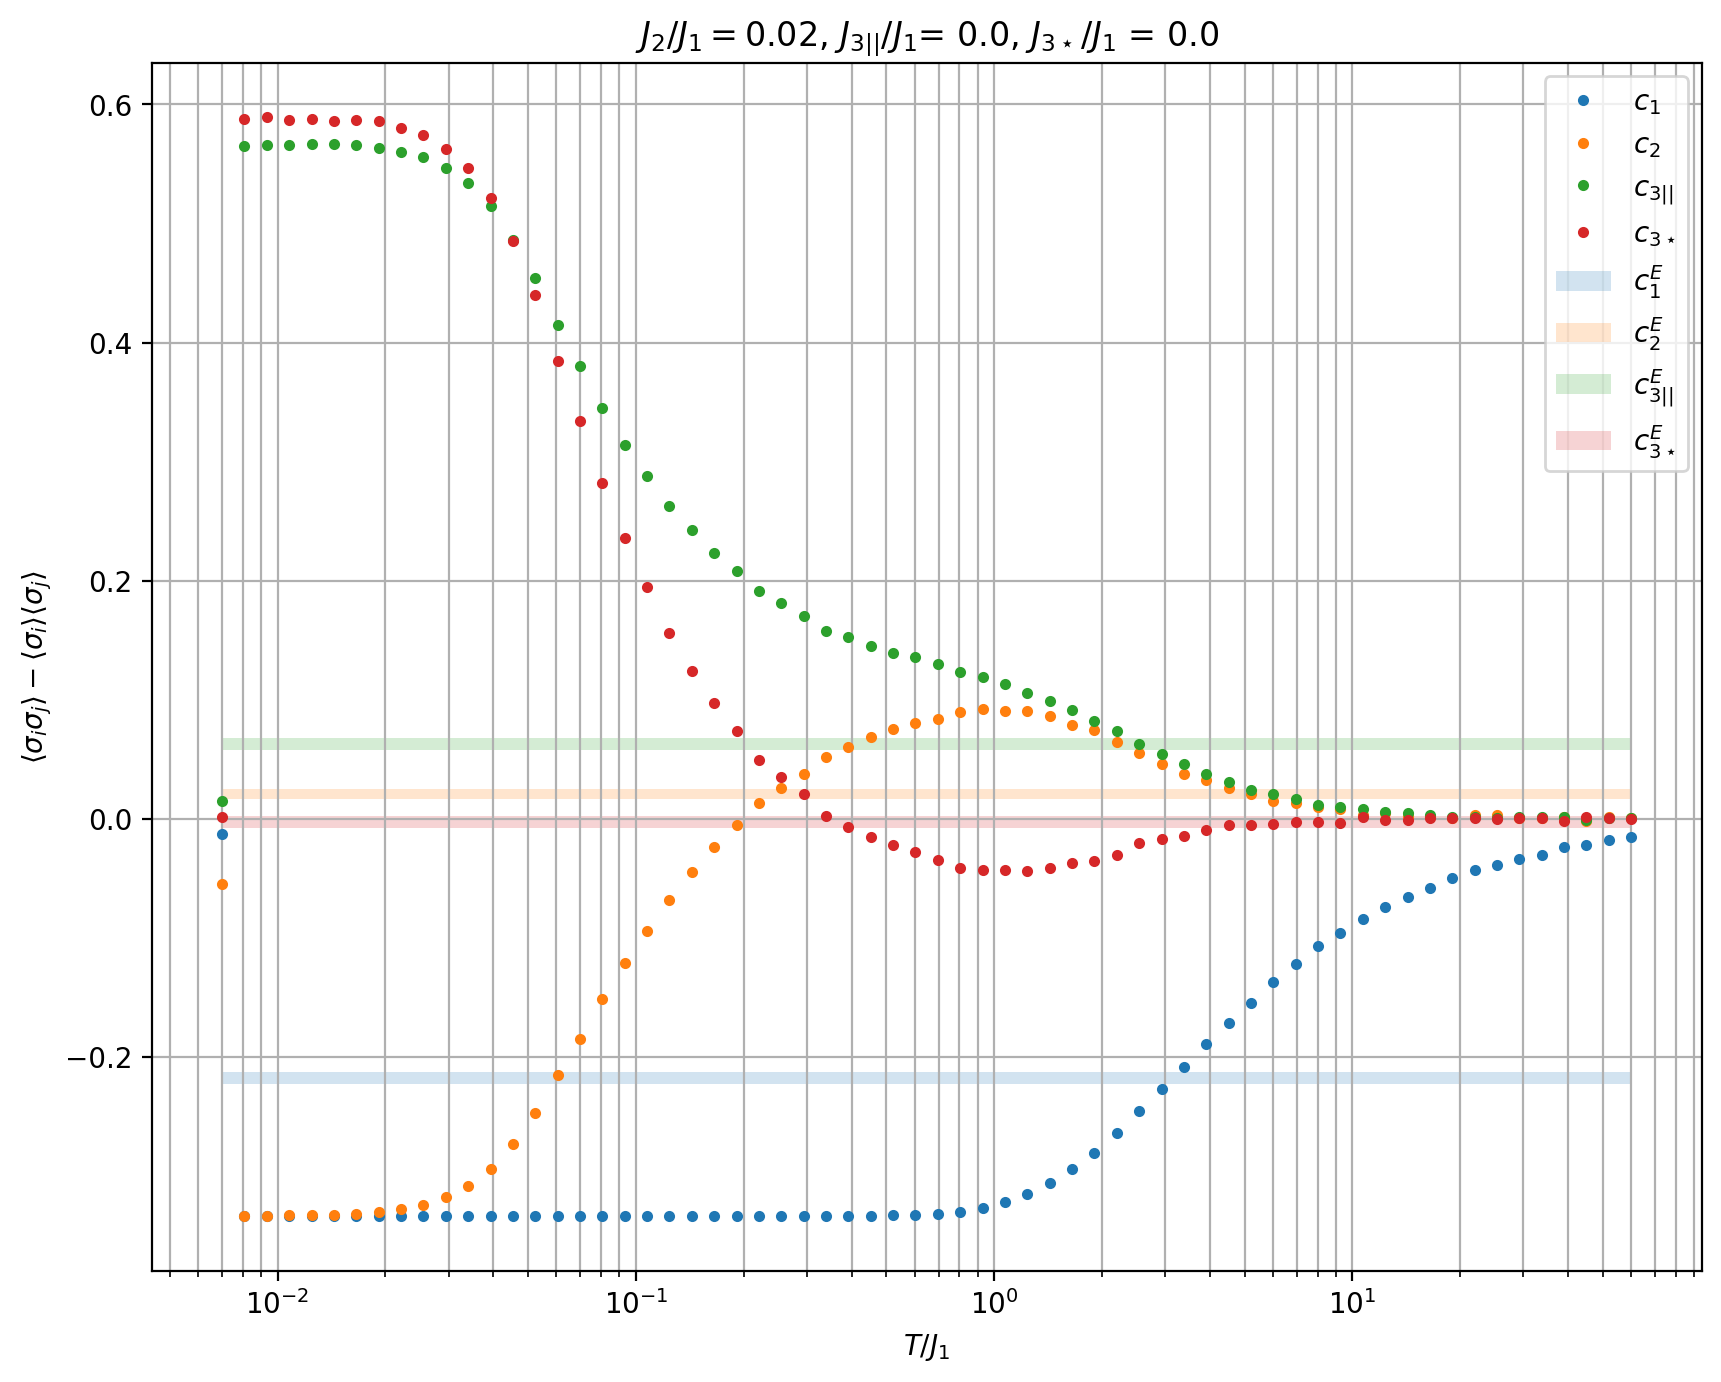

In [18]:
plt.figure(figsize=(10,8), dpi=200)
plt.semilogx(temperatures_plots[0],t_h_MeanFc[0][:,0,0],'.',label = r'$c_1$')
plt.semilogx(temperatures_plots[0],t_h_MeanFc[0][:,0,1],'.',label = r'$c_2$')
plt.semilogx(temperatures_plots[0],t_h_MeanFc[0][:,0,2],'.',label = r'$c_{3||}$')
plt.semilogx(temperatures_plots[0],t_h_MeanFc[0][:,0,3],'.',label = r'$c_{3\star}$')
Tmin = min(temperatures_plots[0])
Tmax = max(temperatures_plots[0])
plt.fill_between([Tmin,Tmax],[NN1exp-NN1experr,NN1exp-NN1experr],[NN1exp+NN1experr, NN1exp+NN1experr], alpha = 0.2, label = r'$c_1^{E}$')
plt.fill_between([Tmin,Tmax],[NN2exp-NN2experr,NN2exp-NN2experr],[NN2exp+NN2experr, NN2exp+NN2experr], alpha = 0.2, label = r'$c_2^{E}$')
plt.fill_between([Tmin,Tmax],[NN3pexp-NN3pexperr,NN3pexp-NN3pexperr],[NN3pexp+NN3pexperr, NN3pexp+NN3pexperr], alpha = 0.2, label = r'$c_{3||}^{E}$')
plt.fill_between([Tmin,Tmax],[NN3sexp-NN3sexperr, NN3sexp-NN3sexperr],[NN3sexp+NN3sexperr, NN3sexp+NN3sexperr], alpha = 0.2, label = r'$c_{3\star}^{E}$')
    
plt.title(r"$J_2/J_1 = {0}$".format(J2[0]/J1[0]) + r", $J_{3||}/J_1 $"+"= {0}".format(J3[0]/J1[0]) +  r", $J_{3\star}/J_1$"+" = {0}".format(J3st[0]/J1[0]))
plt.xlabel(r"$T/J_1$")
plt.ylabel(r"$\langle \sigma_i \sigma_j \rangle - \langle \sigma_i \rangle \langle \sigma_j \rangle$")
plt.grid(which='both')
plt.legend()
plt.savefig("./" + foldername + results_foldername + "/FirstCorrelations_rmmag{0}.png".format(rmmag))

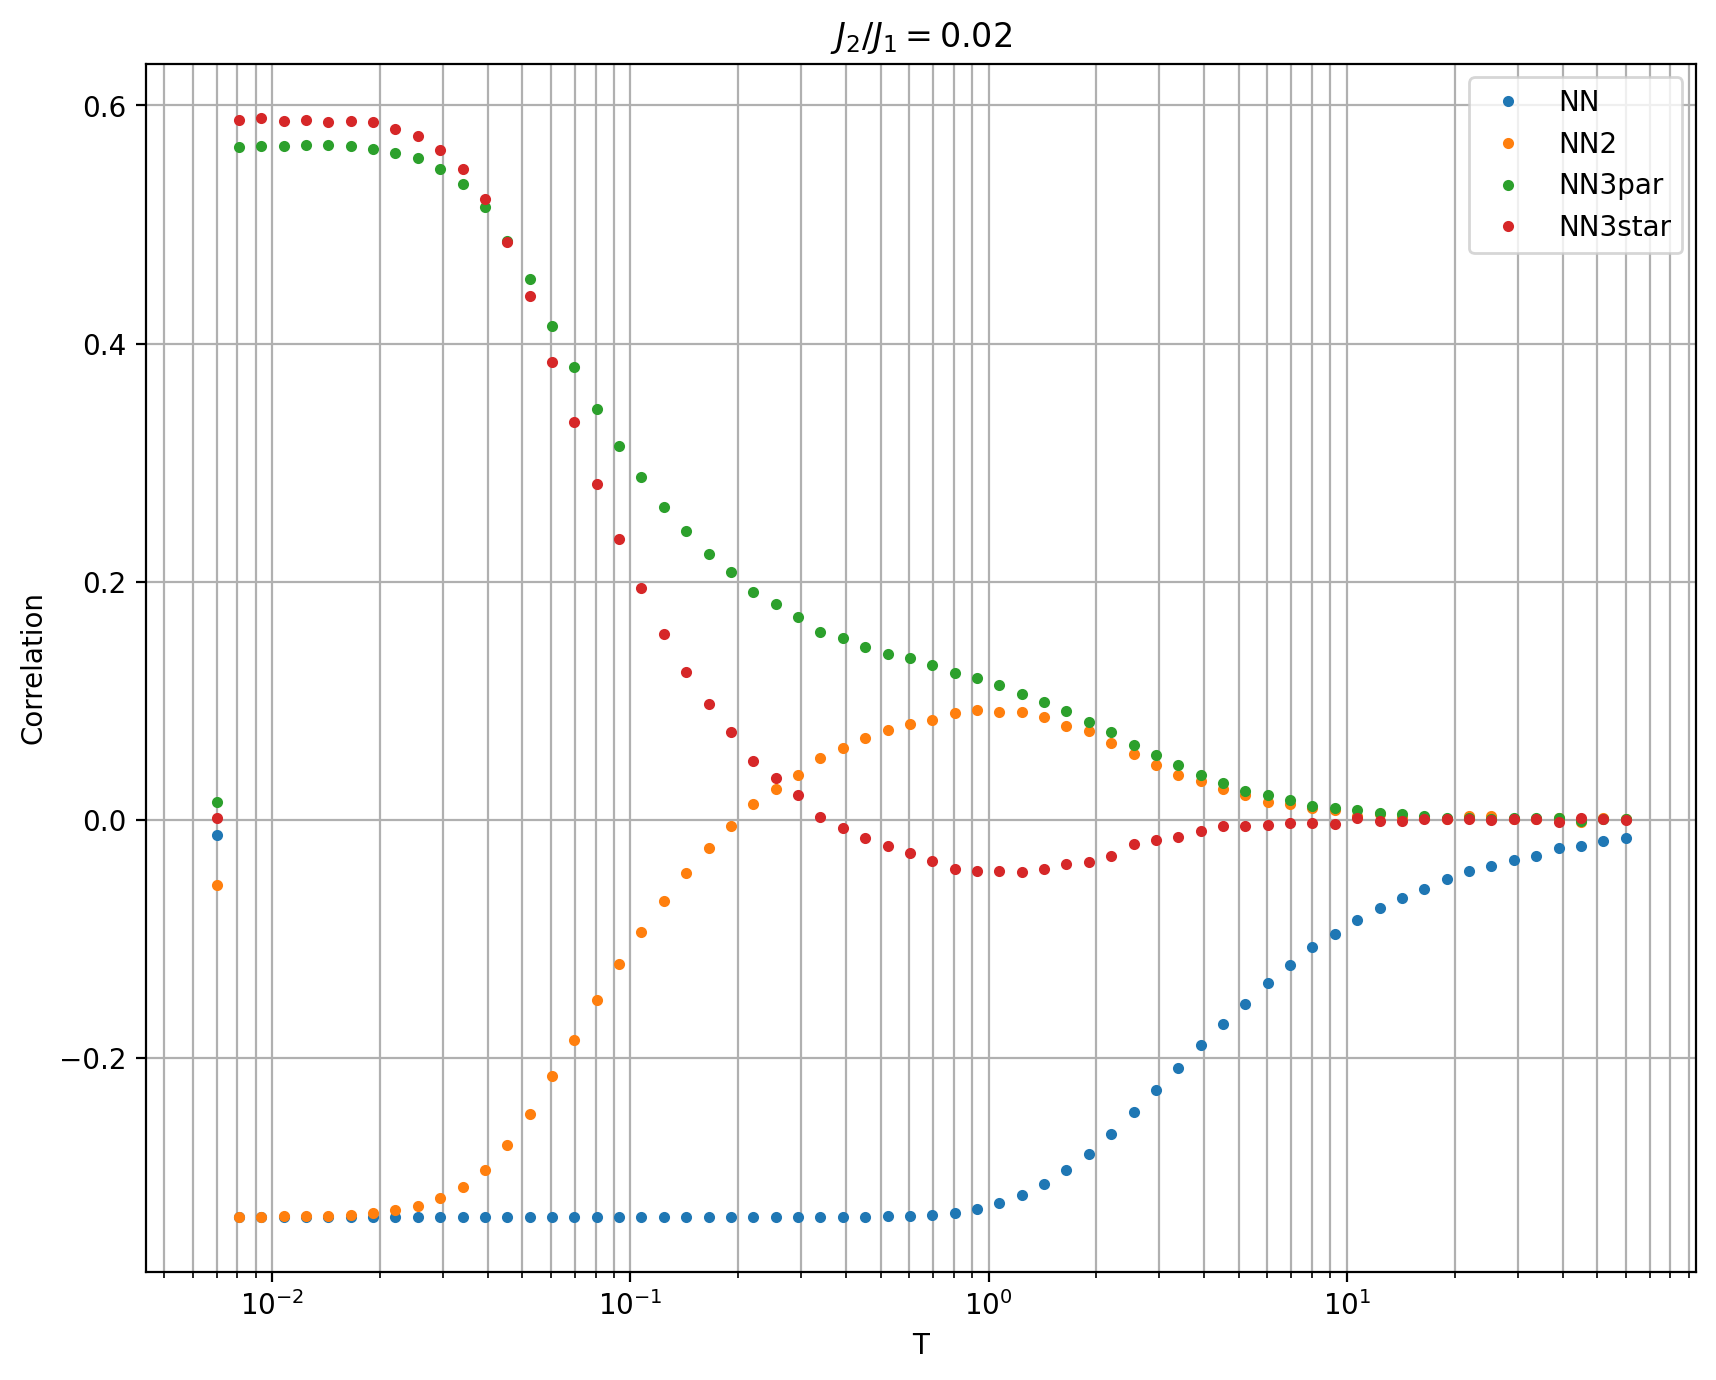

In [19]:
plt.figure(figsize=(10,8), dpi=200)
tmin = 0
plt.semilogx(temperatures_plots[0][tmin:],t_h_MeanFc[0][tmin:,0,0],'.',label = 'NN')
plt.semilogx(temperatures_plots[0][tmin:],t_h_MeanFc[0][tmin:,0,1],'.',label = 'NN2')
plt.semilogx(temperatures_plots[0][tmin:],t_h_MeanFc[0][tmin:,0,2],'.',label = 'NN3par')
plt.semilogx(temperatures_plots[0][tmin:],t_h_MeanFc[0][tmin:,0,3],'.',label = 'NN3star')
plt.title(r"$J_2/J_1 = {0}$".format(J2[0]))
plt.xlabel("T")
plt.ylabel("Correlation")
plt.grid(which='both')
plt.legend()
plt.savefig("./" + foldername + results_foldername + "/ZoomFirstCorrelations_rmmag{0}.png".format(rmmag))

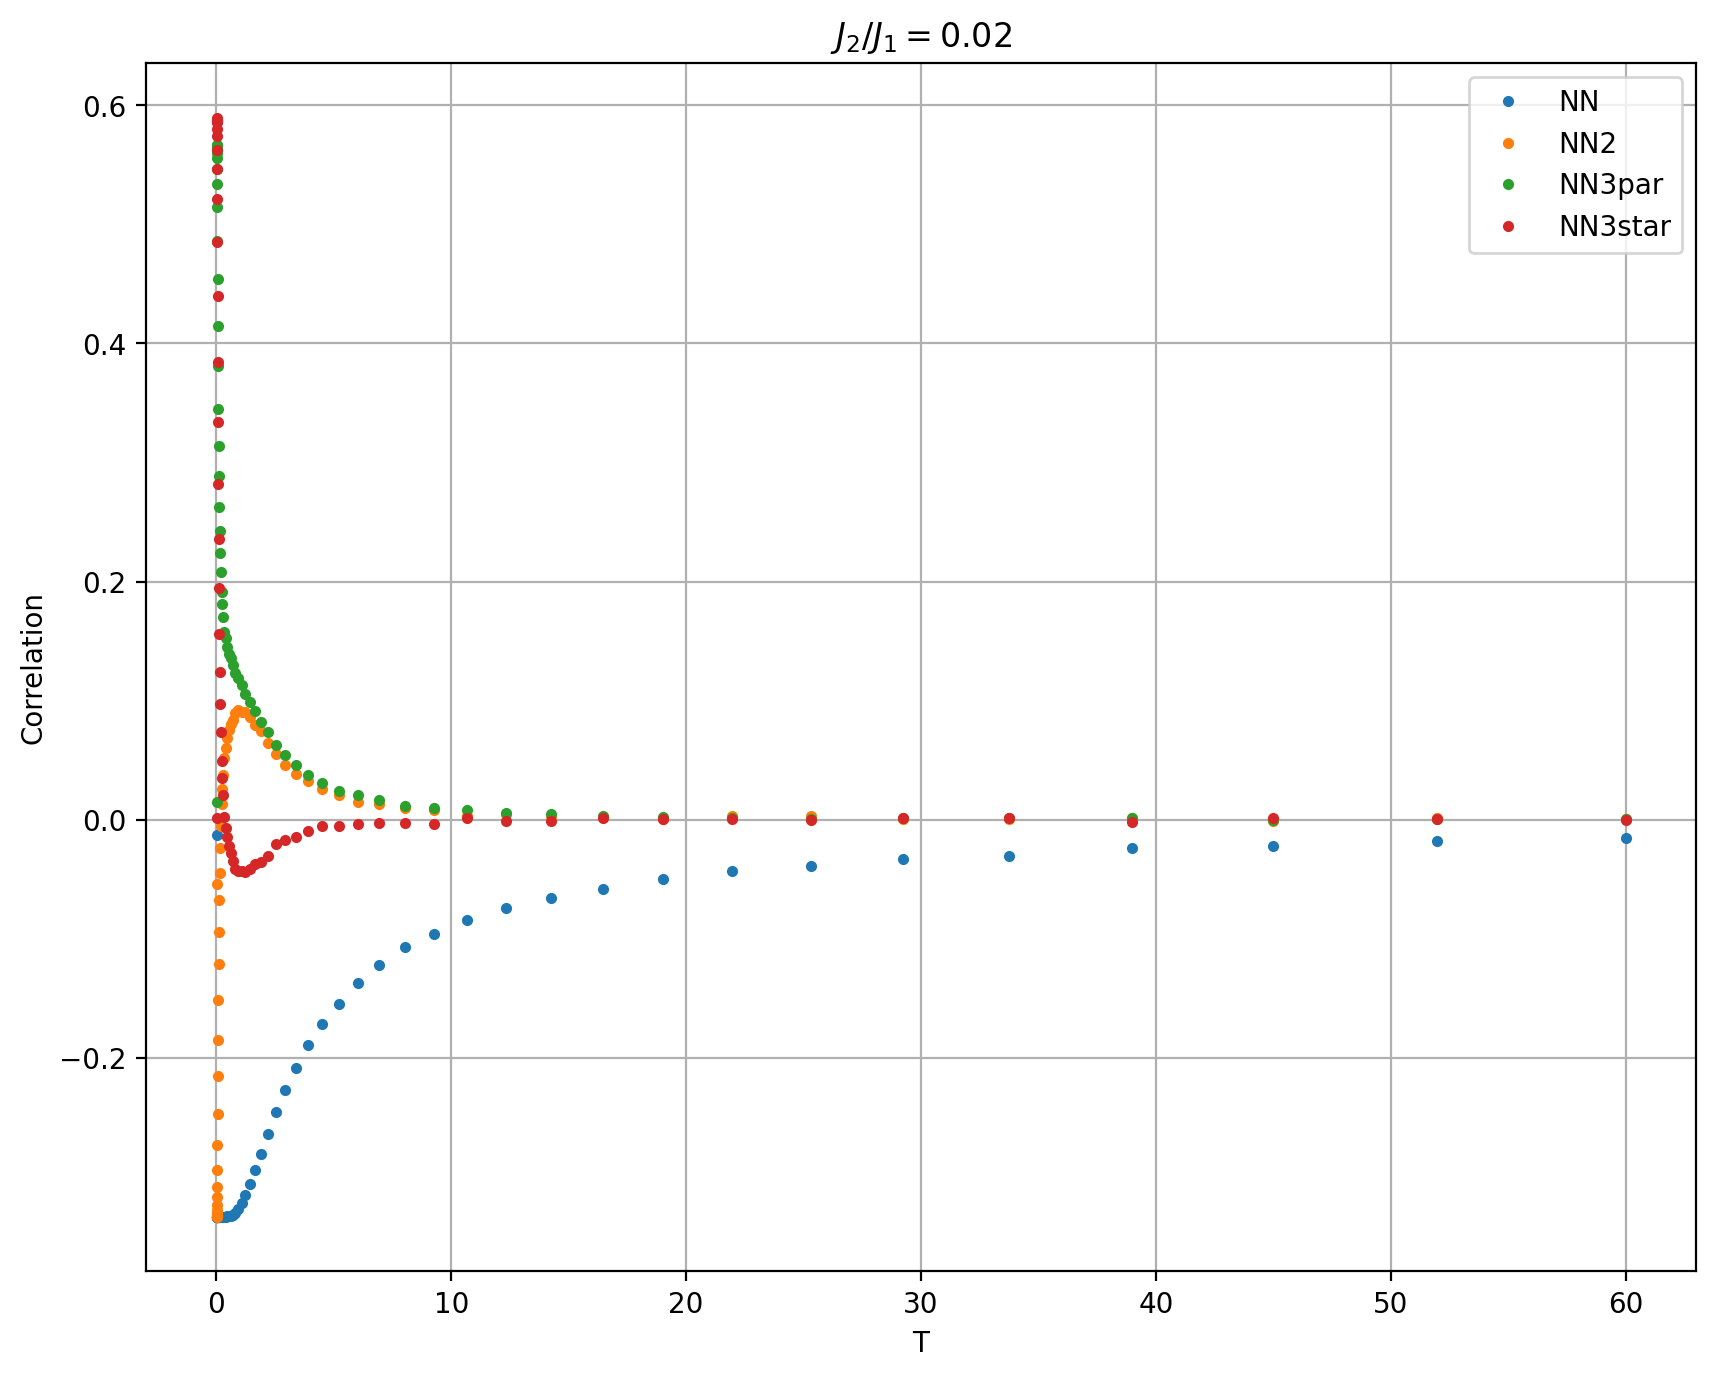

In [20]:
plt.figure(figsize=(10,8), dpi=200)
tmax = 100
plt.plot(temperatures_plots[0][tmin:tmax],t_h_MeanFc[0][tmin:tmax,0,0],'.',label = 'NN')
plt.plot(temperatures_plots[0][tmin:tmax],t_h_MeanFc[0][tmin:tmax,0,1],'.',label = 'NN2')
plt.plot(temperatures_plots[0][tmin:tmax],t_h_MeanFc[0][tmin:tmax,0,2],'.',label = 'NN3par')
plt.plot(temperatures_plots[0][tmin:tmax],t_h_MeanFc[0][tmin:tmax,0,3],'.',label = 'NN3star')
plt.title(r"$J_2/J_1 = {0}$".format(J2[0]))
plt.xlabel("T")
plt.ylabel("Correlation")
plt.grid(which='both')
plt.legend()
plt.savefig("./" + foldername + results_foldername + "/ZoomFirstCorrelations_Linear_rmmag{0}.png".format(rmmag))

In [21]:
kw = {'rmmag': rmmag}
t_h_MeanSs, t_h_varMeanSs, t_h_MeanSi, t_h_varMeanSi, t_h_MeanCorr, t_h_errCorrEstim = \
 af.LoadCentralCorrelations(foldername, filenamelist, listfunctions, sref, stat_temps[0:4], stat_hfields, nb, **kw)

In [22]:
### COMPUTING CORRELATIONS FROM <SISJ> AND <SI> and plotting in 2D
ploth = False
if not ploth:
    tid = 0
    hid = 0
    rid = tid
else:
    tid = 9
    hid = 15
    rid = hid

#[corr, errcorr, maxerr] = af.PrepPlot2DCorrelations(rid, n, 
#                                                t_h_MeanCorr,
#                                                t_h_errCorrEstim,
#                                                t_h_MeanSi,
#                                                hfields_plots,
#                                                temperatures_plots,\
#                                                ploth = ploth)
print("t = ",temperatures_plots[0][tid])
print("h = ",hfields_plots[0][hid])

t =  0.007000000000000002
h =  0.0


[-0.29214128 -0.30016994  0.48281256  0.51753362]


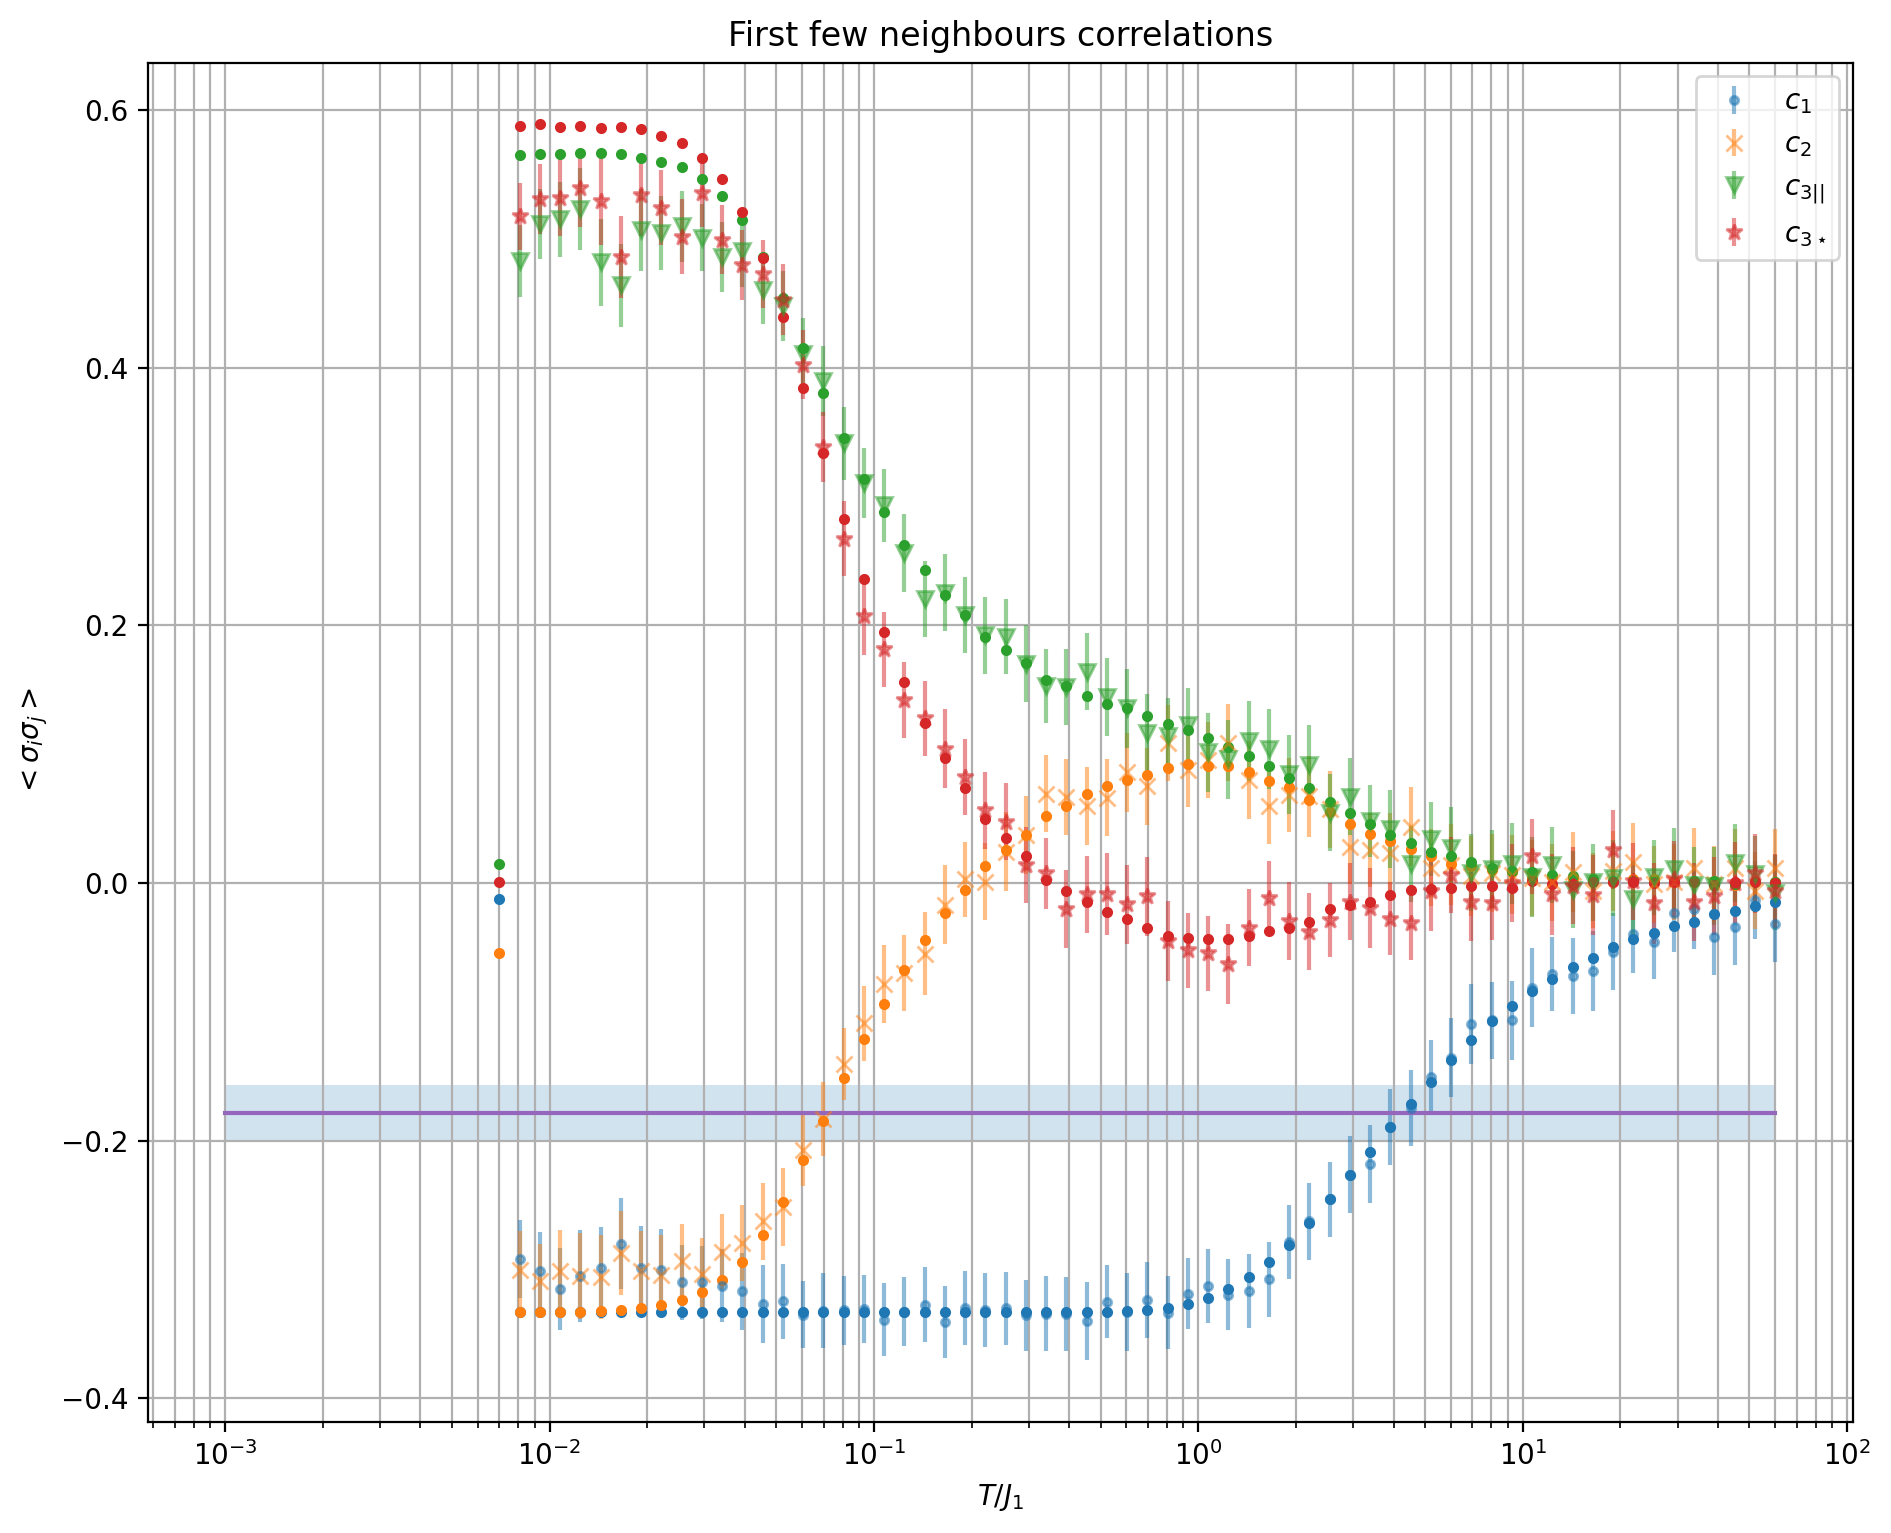

In [23]:
af.PlotFirstCorrelations(0, L,foldername, results_foldername, 
                         hfields_plots, temperatures_plots,
                         t_h_MeanCorr, t_h_errCorrEstim, sref,\
                         distmax = 2, ploth = ploth,
                         plotFirst = True, t_h_MeanFc = t_h_MeanFc)
plt.plot([1e-3,60],[-0.179, -0.179])
plt.fill_between([1e-3,60],[-0.2, -0.2], [-0.157, -0.157], alpha = 0.2)

In [24]:
t_h_MeanFrustratedTriangles, t_h_varMeanFrustratedTriangles= \
 af.LoadFrustratedTriangles(foldername, filenamelist, listfunctions, stat_temps, stat_hfields, nb, **kw)

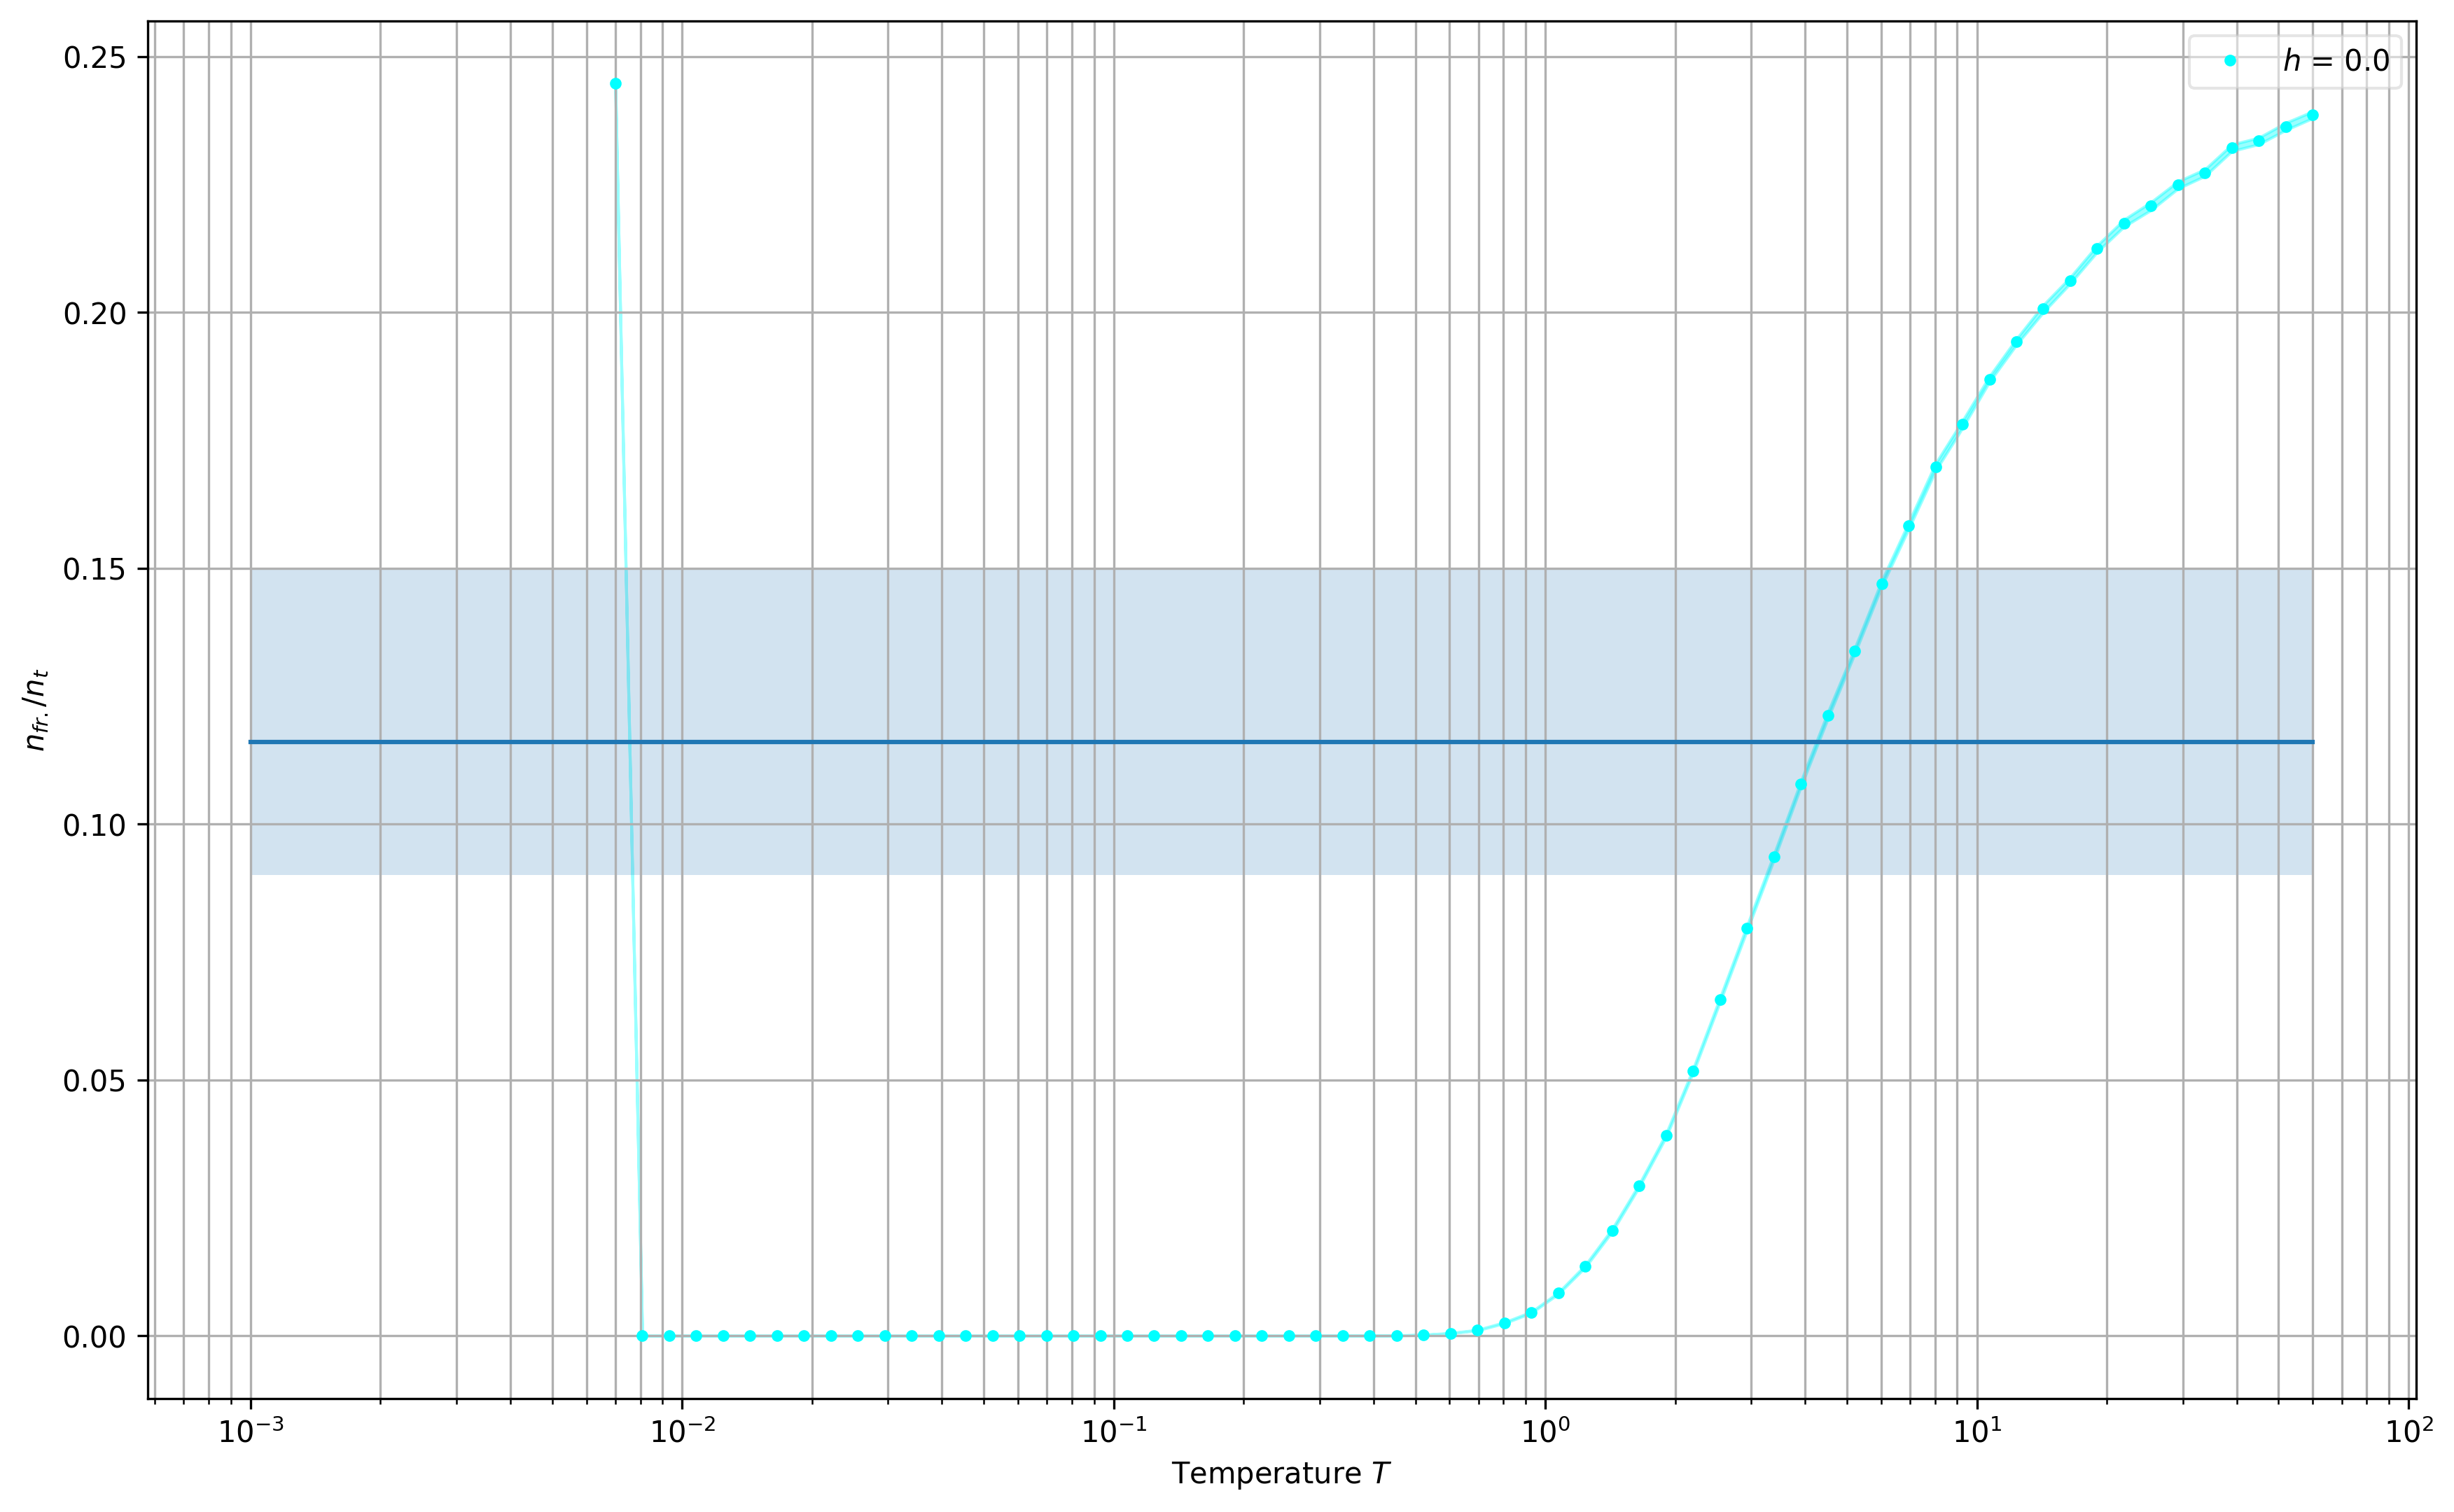

In [25]:
af.BasicPlotsTriangles(L, n, tidmin, tidmax, temperatures_plots, hfields_plots, foldername,
                results_foldername, filenamelist, t_h_MeanFrustratedTriangles,
                        t_h_varMeanFrustratedTriangles, **kw)
plt.plot([1e-3,60],[0.116, 0.116])
plt.fill_between([1e-3,60],[0.09, 0.09], [0.15, 0.15], alpha = 0.2)